In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# /kaggle/input/song-popularity/dataset.csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Описание признаков

1. **Unnamed: 0** — столбец, дублирующий индекс

2. **track_id** — уникальный идентификатор трека. Используется для идентификации песни в базе данных.

3. **artists** — имя исполнителя или группы, записавшей трек.

4. **album_name** — название альбома, в который входит трек.

5. **track_name** — название трека.

6. **popularity** — показатель популярности трека, где большее значение означает более популярный трек. Значения в диапазоне от 0 до 100.

7. **duration_ms** — длительность трека в миллисекундах.

8. **explicit** — флаг, указывающий на наличие ненормативной лексики. Значение `True` означает, что трек содержит контент для взрослых, `False` — что не содержит.

9. **danceability** — коэффициент танцевальности. Это числовой показатель от 0 до 1, отражающий, насколько трек подходит для танцев.

10. **energy** — показатель «энергии» трека. Значение от 0 до 1, где высокий уровень энергии означает быстрый и громкий трек.

11. **key** — тональность трека, представлена в числовом виде.

12. **loudness** — средняя громкость трека в децибелах (dB), где более высокое значение соответствует более громкому треку.

13. **mode** — режим тональности, где `1` — мажор, `0` — минор.

14. **speechiness** — показатель речевого контента. Значение от 0 до 1, где более высокие значения означают большую долю слов в треке.

15. **acousticness** — показатель акустичности, от 0 до 1. Чем ближе к 1, тем выше вероятность, что трек является акустическим.

16. **instrumentalness** — показатель инструментальности, от 0 до 1, где значения ближе к 1 указывают на отсутствие вокала. Небольшие значения могут означать вокал или речь.

17. **liveness** — показатель «живости» трека, от 0 до 1. Более высокие значения указывают на присутствие аудитории и элементы живого исполнения.

18. **valence** — показатель настроения трека, от 0 до 1. Высокие значения означают «позитивное» звучание, тогда как низкие значения связаны с меланхоличным или негативным настроением.

19. **tempo** — темп трека.

20. **time_signature** — размер трека, который представляет количество долей в одном такте.

21. **track_genre** — жанр трека, такой как "acoustic", "pop", "rock", и т.д.


# Загрузка датасета

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
import tensorflow as tf
%matplotlib inline

Проверяю на чём обучается модель: CPU или GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"Модель обучается на GPU: {device_name}")
else:
    print("Модель обучается на CPU")

Модель обучается на CPU


In [ ]:
BASE_URL = '/content/drive/MyDrive/Программирование нейронных сетей/songs_spotify/'

In [ ]:
data = pd.read_csv(f'{BASE_URL}dataset_spotify_init.csv')

In [ ]:
data_initial = data.copy(deep=True)

In [ ]:
data.head()

Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610  ...    -6.746     0       0.1430        0.0322   
1         0.420  0.1660  ...   -17.235     1       0.0763        0.9240   
2         0.438  0.3590  ...    -9.734     1       0.0557        0.2100   
3         0.266  0.0596  ...   -18.515     1       0.0363        0.9050   
4         0.618  0.4430  ...    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature  track_genre  
0          0.000001    0.3580    0.715   87.917               4     acoustic  
1          0.000006    0.1010    0.267   77.489               4     acoustic  
2          0.000000    0.1170    0.120   76.332               4     acoustic  
3          0.000071    0.1320    0.143  181.740               3     acoustic  
4          0.000000    0.0829    0.167  119.949               4     acoustic  

[5 rows x 21 columns]

In [ ]:
data.shape

(114000, 21)

In [ ]:
data_initial.head()

Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610  ...    -6.746     0       0.1430        0.0322   
1         0.420  0.1660  ...   -17.235     1       0.0763        0.9240   
2         0.438  0.3590  ...    -9.734     1       0.0557        0.2100   
3         0.266  0.0596  ...   -18.515     1       0.0363        0.9050   
4         0.618  0.4430  ...    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature  track_genre  
0          0.000001    0.3580    0.715   87.917               4     acoustic  
1          0.000006    0.1010    0.267   77.489               4     acoustic  
2          0.000000    0.1170    0.120   76.332               4     acoustic  
3          0.000071    0.1320    0.143  181.740               3     acoustic  
4          0.000000    0.0829    0.167  119.949               4     acoustic  

[5 rows x 21 columns]

In [ ]:
data.shape

(114000, 21)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

# Обработка DataFrame

In [ ]:
data['popularity'].value_counts()

popularity
0      16020
22      2354
21      2344
44      2288
1       2140
       ...  
96         7
94         7
95         5
100        2
99         1
Name: count, Length: 101, dtype: int64

In [ ]:
data['popularity'].unique()

array([ 73,  55,  57,  71,  82,  58,  74,  80,  56,  69,  52,  62,  54,
        68,  67,  75,  63,  70,   0,   1,  46,  61,  60,  51,  66,  64,
        65,  44,  45,  50,  59,  49,  53,  47,  43,  42,  20,  22,  35,
        19,  24,  18,  23,  40,  38,  41,  30,  37,  39,  48,  36,  34,
        26,  32,  33,  21,  31,  28,  29,  27,  25,  16,   3,  12,   7,
        10,   9,  11,  17,   8,  15,  87,  83,  86,  93,  76,  78,   4,
         2,   5,  85,  81,  84,  72,  79,  77,   6,  13,  14,  89,  96,
       100,  98,  88,  92,  90,  91,  99,  97,  95,  94])

In [ ]:
data.isnull().sum()

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [ ]:
data = data.dropna()

In [ ]:
data.isnull().sum()

Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [ ]:
data.shape

(113999, 21)

In [ ]:
data = data.drop(['Unnamed: 0', 'track_id'], axis=1)

In [ ]:
numerical_features = data.select_dtypes(include=['number']).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

In [ ]:
numerical_features

['popularity',
 'duration_ms',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature']

In [ ]:
categorical_features

['artists', 'album_name', 'track_name', 'track_genre']

In [ ]:
categorical_cols = data.select_dtypes(include=['object']).columns
label_encoders = {}

In [ ]:
from sklearn.preprocessing import LabelEncoder
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artists           113999 non-null  int64  
 1   album_name        113999 non-null  int64  
 2   track_name        113999 non-null  int64  
 3   popularity        113999 non-null  int64  
 4   duration_ms       113999 non-null  int64  
 5   explicit          113999 non-null  bool   
 6   danceability      113999 non-null  float64
 7   energy            113999 non-null  float64
 8   key               113999 non-null  int64  
 9   loudness          113999 non-null  float64
 10  mode              113999 non-null  int64  
 11  speechiness       113999 non-null  float64
 12  acousticness      113999 non-null  float64
 13  instrumentalness  113999 non-null  float64
 14  liveness          113999 non-null  float64
 15  valence           113999 non-null  float64
 16  tempo             113999 

# Аналитика

In [ ]:
import numpy as np

In [ ]:
sns.set(style="whitegrid")

## Распределение популярности треков

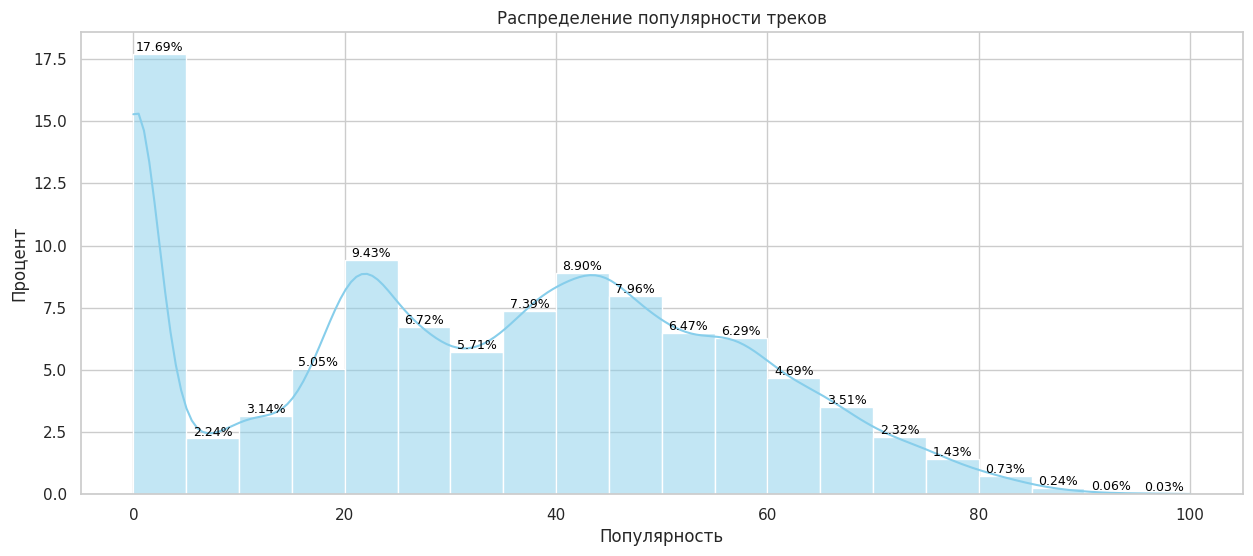

In [ ]:
plt.figure(figsize=(15, 6))
histplot = sns.histplot(data['popularity'], bins=20, kde=True, color='skyblue', stat='percent')
plt.title('Распределение популярности треков')
plt.xlabel('Популярность')
plt.ylabel('Процент')

for p in histplot.patches:
    height = p.get_height()
    # Добавляем подпись, только если высота больше 0
    if height > 0:
        plt.text(p.get_x() + p.get_width() / 2, height, f'{height:.2f}%',
                 ha='center', va='bottom', fontsize=9, color='black')

plt.show()

Видно, что подавляющее большинство треков с популярностью равной 0. Также много треков с популярностью от 20 до 60. С популярностью выше 80 всего около 1% треков

## Процентное соотношение треков с ненормативной лексикой и без

In [ ]:
explicit_counts = data['explicit'].value_counts()
explicit_counts

explicit
False    104252
True       9747
Name: count, dtype: int64

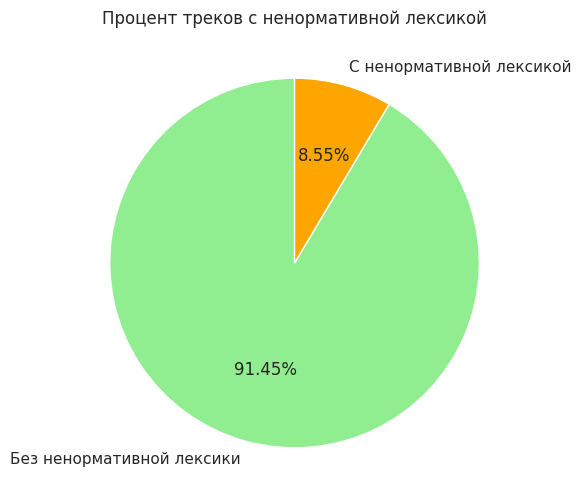

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(explicit_counts, labels=['Без ненормативной лексики', 'С ненормативной лексикой'],
        autopct='%.2f%%', startangle=90, colors=['lightgreen', 'orange'])
plt.title('Процент треков с ненормативной лексикой')
plt.show()


Видно, что треков без ненормативной лексики более чем в 10 раз больше, чем с ненормативной лексикой

## Влияние наличия ненормативной лексики в треке на его среднюю популярность

In [ ]:
explicit_popularity = data_initial.groupby('explicit')['popularity'].mean().reset_index()

<ipython-input-296-d764ef992629>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=explicit_popularity, x='explicit', y='popularity', palette='viridis')


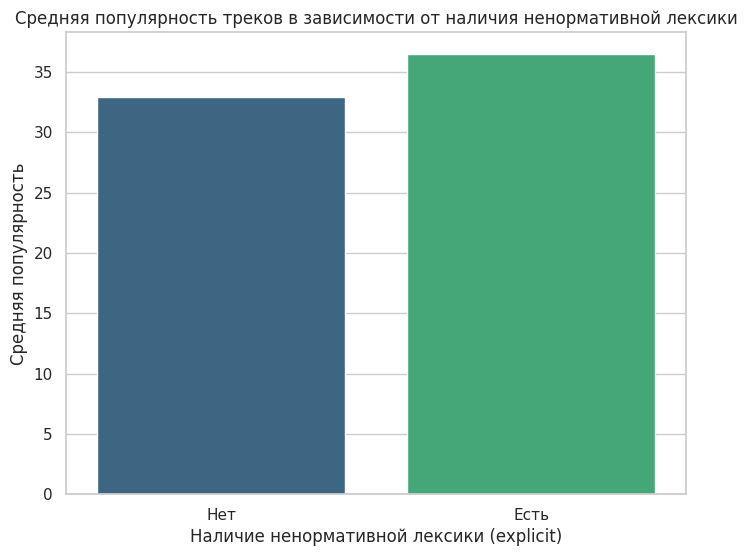

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(data=explicit_popularity, x='explicit', y='popularity', palette='viridis')

plt.title('Средняя популярность треков в зависимости от наличия ненормативной лексики')
plt.xlabel('Наличие ненормативной лексики (explicit)')
plt.ylabel('Средняя популярность')
plt.xticks([0, 1], labels=['Нет', 'Есть'])
plt.show()

На диаграмме показана средняя популярность треков с и без ненормативной лексики. Однако важно учитывать, что количество треков без ненормативной лексики значительно превышает количество треков с её наличием, более чем в 10 раз. Это может влиять на точность результатов. Несмотря на это, видно, что треки с ненормативной лексикой имеют более высокую среднюю популярность по сравнению с треками без неё

## Распределение треков по длительности в минутах

In [ ]:
duration_min = data['duration_ms'] / 60000
max_duration = duration_min.max()
bins = [0, 1, 2, 3, 4, 5, 10, max_duration]

print(duration_min.head())
print('Maximum duration:', max_duration)

0    3.844433
1    2.493500
2    3.513767
3    3.365550
4    3.314217
Name: duration_ms, dtype: float64
Maximum duration: 87.28825


In [ ]:
duration_counts = duration_min.value_counts(bins=bins, sort=False)
duration_counts

(-0.001, 1.0]       872
(1.0, 2.0]         5427
(2.0, 3.0]        26136
(3.0, 4.0]        42384
(4.0, 5.0]        22832
(5.0, 10.0]       15745
(10.0, 87.288]      603
Name: count, dtype: int64

In [ ]:
labels = ['<1 мин', '1-2 мин', '2-3 мин', '3-4 мин', '4-5 мин', '5-10 мин', '10+ мин']

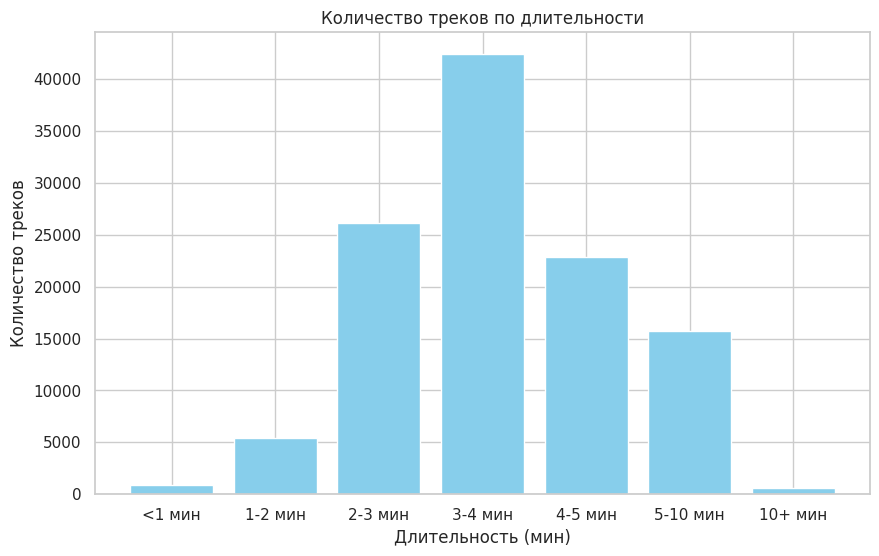

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x=labels, height=duration_counts.values, color='skyblue')
plt.title('Количество треков по длительности')
plt.xlabel('Длительность (мин)')
plt.ylabel('Количество треков')
plt.show()

Видно, что больше всего треков длительностью 3-4 минуты. Также достаточно много треков длительностью 2-3 минуты и 4-10 минут

## Влияние длительности на популярность трека

In [ ]:
duration_min = data_initial['duration_ms'] / 60000
bins = [0, 1, 2, 3, 4, 5, 10, duration_min.max()]
labels = ['<1 мин', '1-2 мин', '2-3 мин', '3-4 мин', '4-5 мин', '5-10 мин', '10+ мин']

data_initial['duration_category'] = pd.cut(duration_min, bins=bins, labels=labels)

duration_popularity = data_initial.groupby('duration_category')['popularity'].mean().reset_index()

<ipython-input-301-cb932e5c02b8>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_popularity = data_initial.groupby('duration_category')['popularity'].mean().reset_index()


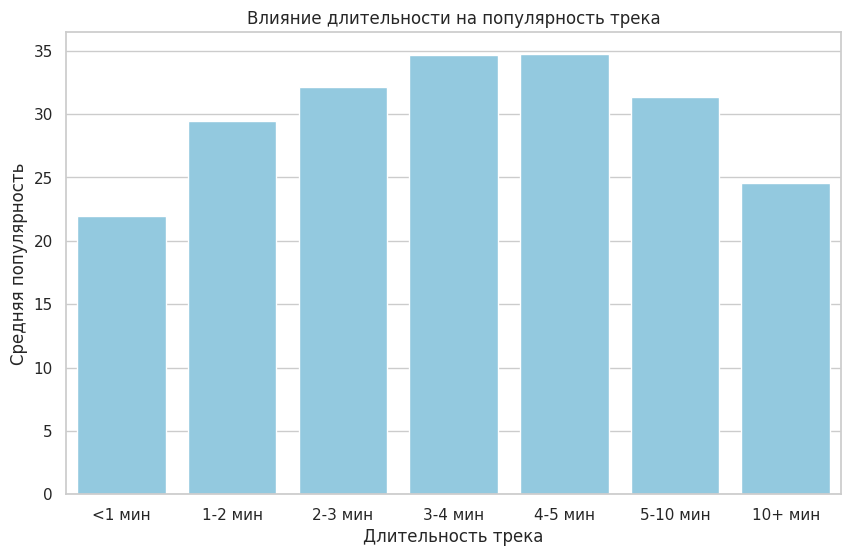

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=duration_popularity, x='duration_category', y='popularity', color='skyblue')

plt.title('Влияние длительности на популярность трека')
plt.xlabel('Длительность трека')
plt.ylabel('Средняя популярность')
plt.show()

Наибольшая средняя популярность у треков с длительностью от 3 до 5 минут. Следом идут треки с длительностью 2-3 минуты и треки длиной 5-10 минут. Худшая популярность у самых коротких треков

##  Распределение треков по жанрам

In [ ]:
genre_counts = data_initial['track_genre'].value_counts()
genre_counts

track_genre
acoustic             1000
punk-rock            1000
progressive-house    1000
power-pop            1000
pop                  1000
                     ... 
folk                 1000
emo                  1000
electronic           1000
electro              1000
world-music          1000
Name: count, Length: 114, dtype: int64

Сделаю предположение, что на каждый жанр приходится по 1000 треков

In [ ]:
maximum_tracks_by_genre = genre_counts.max()
minimum_tracks_by_genre = genre_counts.min()

print(f'Максимум треков по жанрам: {maximum_tracks_by_genre}')
print(f'Минимум треков по жанрам: {minimum_tracks_by_genre}')

Максимум треков по жанрам: 1000
Минимум треков по жанрам: 1000


Предположение подтвердилось. На каждый жанр приходится по 1000 треков

## Влияние жанра на популярность

In [ ]:
genre_popularity = data_initial.groupby('track_genre')['popularity'].mean().reset_index()

# Сортируем по средней популярности (от популярного к непопулярному)
genre_popularity = genre_popularity.sort_values(by='popularity', ascending=False)

top_genres = genre_popularity.head(3)
bottom_genres = genre_popularity.tail(3)

selected_genres = pd.concat([top_genres, bottom_genres])

<ipython-input-306-780cf1d450f3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=selected_genres, x='track_genre', y='popularity', palette='viridis')


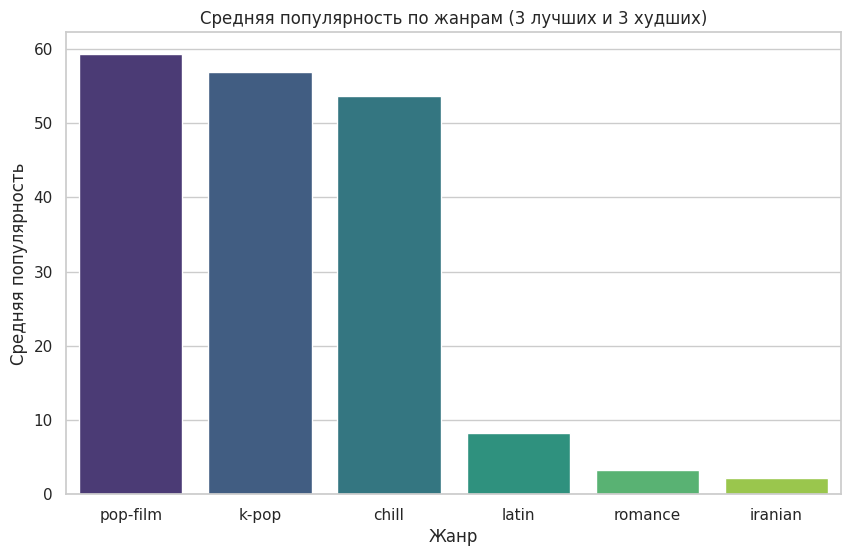

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=selected_genres, x='track_genre', y='popularity', palette='viridis')

plt.title('Средняя популярность по жанрам (3 лучших и 3 худших)')
plt.xlabel('Жанр')
plt.ylabel('Средняя популярность')
# plt.xticks(rotation=45)  # Поворот меток на оси X для удобства
plt.show()

Видно, что:

* наибольшая средняя популярность у таких жанров: *pop-film*, *k-pop* и *chill*
* Худшая средняя популярность у таких жанров: *latin*, *romance* и *iranian*

Из этого можно сделать вывод, что жанр сильно влияет на популярность

## Влияние настроения трека на популярность

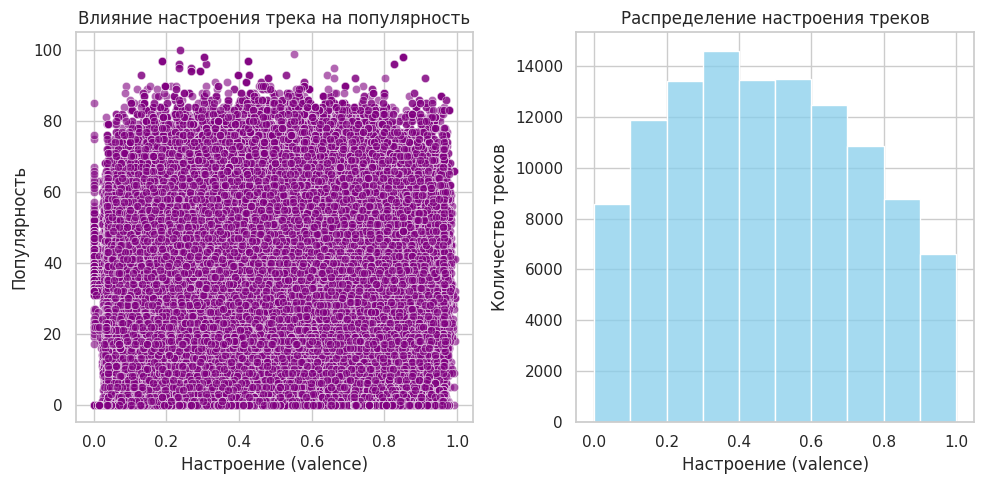

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='valence', y='popularity', data=data_initial, color='purple', alpha=0.6)
plt.title('Влияние настроения трека на популярность')
plt.xlabel('Настроение (valence)')
plt.ylabel('Популярность')

plt.subplot(1, 2, 2)
sns.histplot(data=data_initial['valence'], bins=np.arange(0, 1.1, 0.1), color='skyblue')
plt.title('Распределение настроения треков')
plt.xlabel('Настроение (valence)')
plt.ylabel('Количество треков')

plt.tight_layout()
plt.show()

* Можно сделать вывод, что настроение трека не влияет на его популярность, так как при любом настроении его популярность кардинально не меняется.
* Треков с грустным звучанием немного больше, чем треков с позитивным звучанием

## Влияние танцевальности и энергичности на популярность

In [ ]:
bins = np.arange(0, 1.1, 0.1)

data_initial['dance_bin'] = pd.cut(data_initial['danceability'], bins=bins)
data_initial['energy_bin'] = pd.cut(data_initial['energy'], bins=bins)

heatmap_data = data_initial.groupby(['dance_bin', 'energy_bin']).popularity.mean().reset_index()

heatmap_pivot = heatmap_data.pivot(index='dance_bin', columns='energy_bin', values='popularity')

<ipython-input-308-df3b0e7bfbbf>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = data_initial.groupby(['dance_bin', 'energy_bin']).popularity.mean().reset_index()


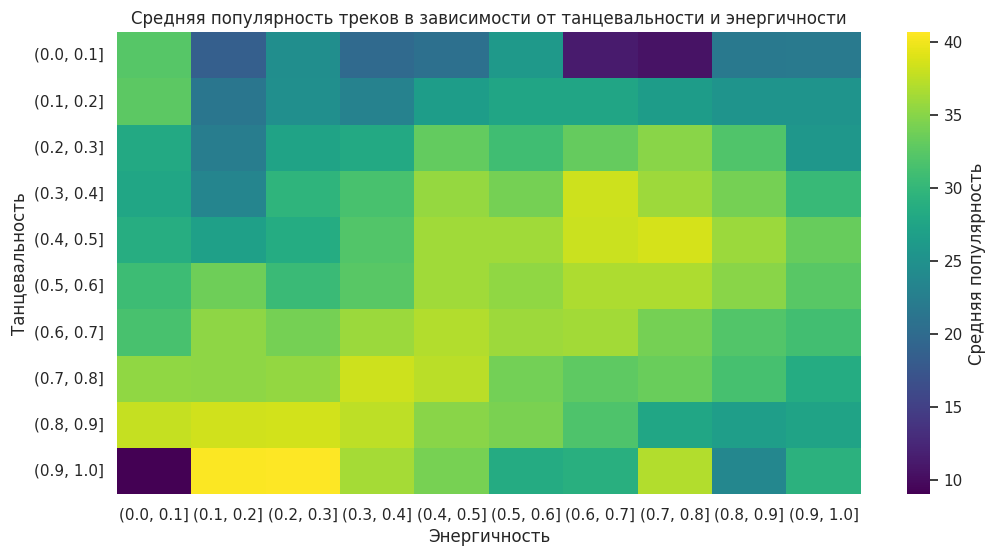

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_pivot,
    cmap='viridis',
    cbar=True,
    cbar_kws={'label': 'Средняя популярность'}
)

plt.title('Средняя популярность треков в зависимости от танцевальности и энергичности')
plt.xlabel('Энергичность')
plt.ylabel('Танцевальность')
plt.show()

Видно, что наибольшая средняя популярность достигается при энергичности трека в диапазоне (0.1, 0.3] и танцевальности трека в диапазоне (0.9, 1.0]

Можно сказать, что данная комбинация признаков влияет на популярность

## Построение корреляционной матрицы всех признаков

**Корреляция** измеряет силу и направление линейной связи между двумя переменными. В контексте анализа данных она помогает понять, насколько одна переменная может предсказывать изменения в другой.

**Интерпретация значений корреляции:**

1. Положительная корреляция:
  * Если корреляция положительная (больше 0), это означает, что по мере увеличения одной переменной увеличивается и другая
2. Отрицательная корреляция:
  * Если корреляция отрицательная (меньше 0), это означает, что при увеличении одной переменной другая уменьшается
3. Отсутствие корреляции:
  * Значение корреляции, близкое к 0, говорит о том, что между переменными нет линейной связи

In [ ]:
correlation_matrix = data.corr()

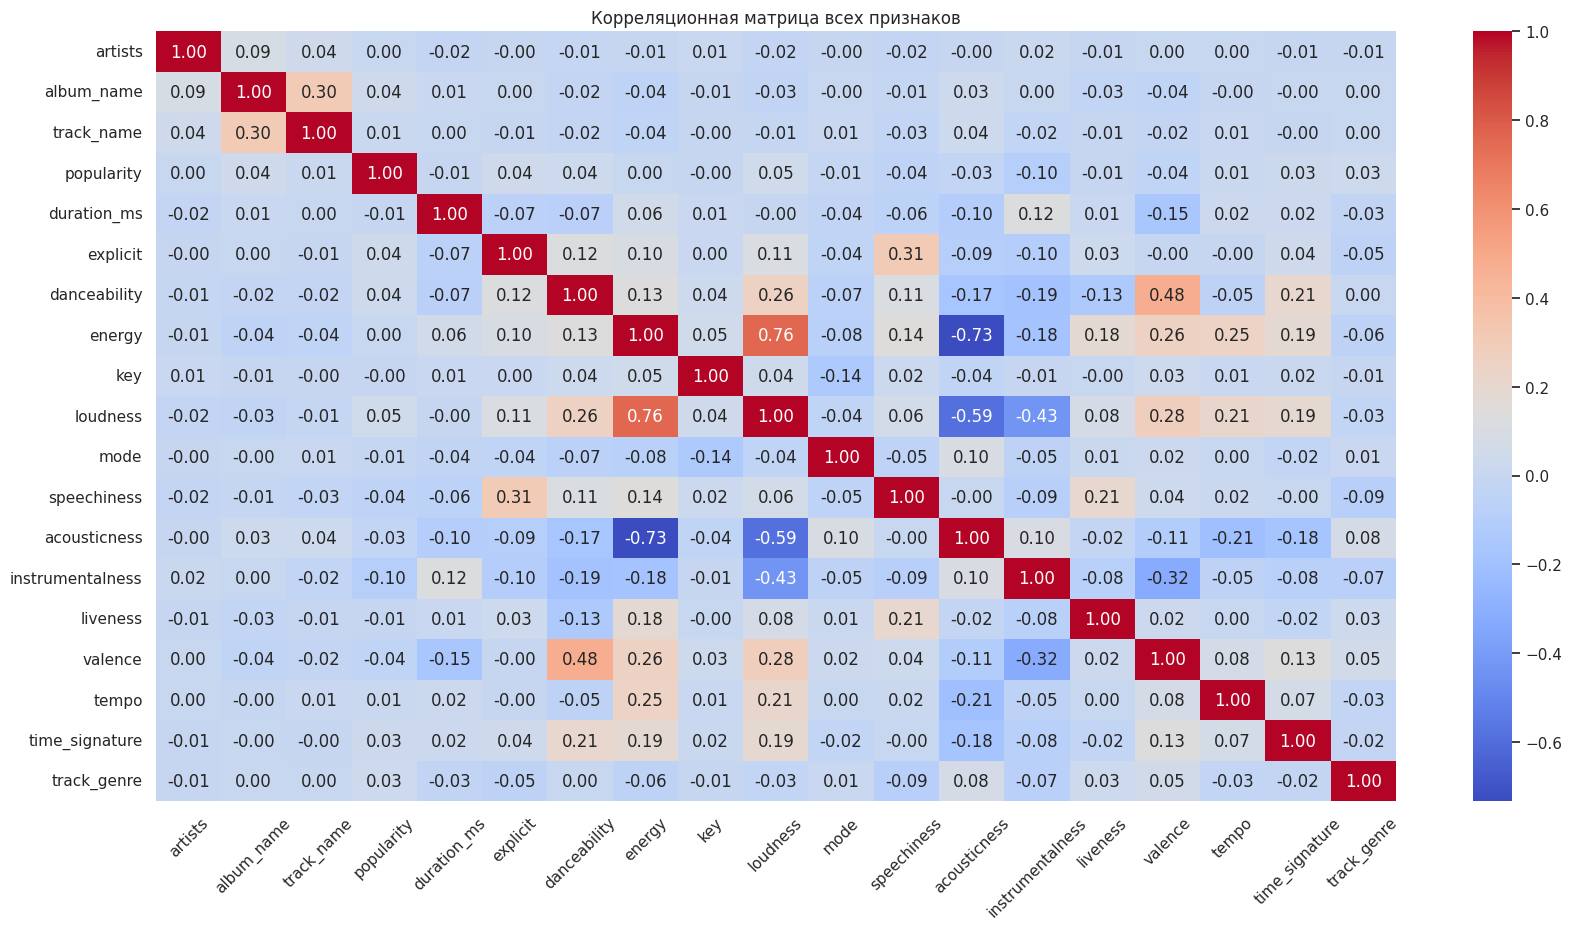

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляционная матрица всех признаков")
plt.xticks(rotation=45)
plt.show()

На основании корреляционной матрицы можно сделать следующие выводы:
  1. Популярность трека не коррелирует ни с одним из других признаков. Из этого можно сделать вывод, что между популярностью и другими признаками отсутствует линейная зависимость
  2. Положительная (прямая) корреляция:
    * ***loudness*** и ***energy*** имеют значимую положительную корреляцию (0.76), что указывает на то, что энергичные треки являются более громкими
    * ***valence*** и ***danceability*** имеют умеренную положительную корреляцию (0.48). Это говорит о том, что позитивные треки чаще бывают танцевальными
    * ***speechiness*** и ***explicit*** имеют положительную корреляцию (0.31), это свидетельствует о том, что в треках, в которых большое количество слов, скорее всего будет ненормативная лексика. В пример можно привести такой жанр как рэп
  3. Отрицательная (обратная) корреляция:
    * ***energy*** и ***acousticness*** имеют значительную отрицательную корреляцию (-0.73), что показывает: чем энергичнее трек, тем меньше вероятность, что он будет акустическим
    * ***acousticness*** и ***loudness*** имеют сильную отрицательную корреляцию (-0.59). Это значит, что акустический треки имеют более тихое звучание
    * ***instrumentalness*** и ***loudness*** имеют отрицательную корреляцию (-0.43), указывая на то, что инструментальные треки обычно имеют тихое звучание

  **Итог:**

  Взаимосвязь между ***loudness*** и ***energy***, ***valence*** и ***danceability***, а также ***speechiness*** и ***explicit*** подчеркивает, что эти признаки тесно связаны. Отрицательные корреляции ***acousticness*** с ***energy*** и ***loudness*** подтверждают интуитивное понимание, что более акустическая музыка обычно менее энергична и громка. Отрицательная корреляция между ***instrumentalness*** и ***loudness*** показывает, что инструментальные треки обычно менее тихие

## Влияние количества слов и наличия ненормативной лексики в треке на популярность

In [ ]:
speech_explicit_score = data['speechiness'] * data['explicit']

In [ ]:
speech_explicit_score.value_counts()

0.0000    104252
0.1020        68
0.0872        65
0.0554        62
0.1710        59
           ...  
0.5640         1
0.0263         1
0.5150         1
0.6910         1
0.0794         1
Name: count, Length: 1339, dtype: int64

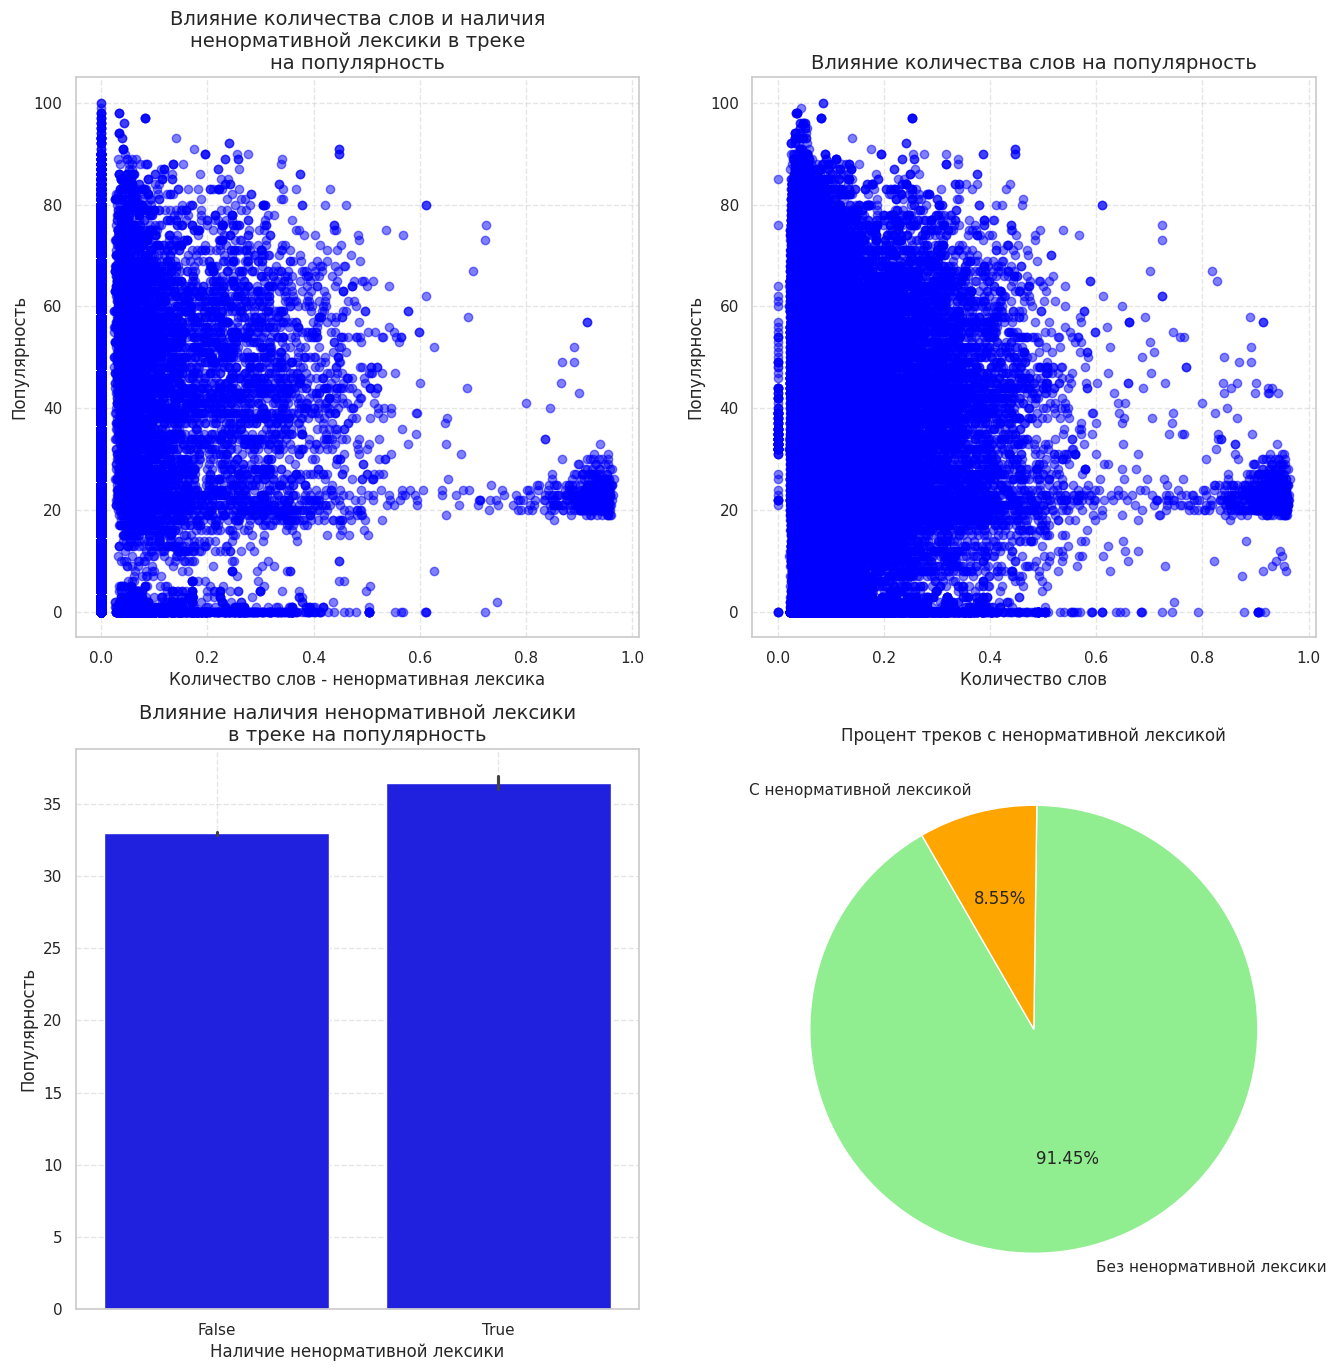

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)
plt.scatter(speech_explicit_score, data['popularity'], alpha=0.5, c='blue')
plt.title("Влияние количества слов и наличия\nненормативной лексики в треке\nна популярность", fontsize=14)
plt.xlabel("Количество слов - ненормативная лексика", fontsize=12)
plt.ylabel("Популярность", fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.subplot(2, 2, 2)
plt.scatter(data['speechiness'], data['popularity'], alpha=0.5, c='blue')
plt.title("Влияние количества слов на популярность", fontsize=14)
plt.xlabel("Количество слов", fontsize=12)
plt.ylabel("Популярность", fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.subplot(2, 2, 3)
sns.barplot(data=data, x='explicit', y='popularity', color='blue')
plt.title("Влияние наличия ненормативной лексики\nв треке на популярность", fontsize=14)
plt.xlabel("Наличие ненормативной лексики", fontsize=12)
plt.ylabel("Популярность", fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.subplot(2, 2, 4)
plt.pie(data['explicit'].value_counts(), labels=['Без ненормативной лексики', 'С ненормативной лексикой'],
        autopct='%.2f%%', startangle=120, colors=['lightgreen', 'orange'])
plt.title('Процент треков с ненормативной лексикой')
plt.show()

plt.tight_layout()
plt.show()

Видно, что наибольшую популярность получают треки, у которых либо отсутствует ненормативная лексика, либо треки, у которых ненормативная лексика присутствует, но количество слов в песне минимально. Также можно увидеть, что треков без ненормативной лексики намного больше чем с её наличием

Из этого можно сделать вывод, что признак "Количество слов в треке и наличие ненормативной лексики" некорректен, так как треков без ненормативной лексики более чем в 10 раз больше, чем с её наличием

In [ ]:
popularity_speech_explicit_corr = data['popularity'].corr(speech_explicit_score)
print(f'Корреляция между "Количество слов - ненормативная лексика" и популярностью: {popularity_speech_explicit_corr:.2f}')

Корреляция между "Количество слов - ненормативная лексика" и популярностью: 0.00


Корреляция между ***popularity*** и ***speech_explicit_score*** равна 0. Это говорит о том, что нет линейной зависимости между данными признаками

## Влияние настроения и танцевальности трека на популярность

In [ ]:
valence_dancebility = data['valence'] * data['danceability']

In [ ]:
valence_dancebility.head()

0    0.483340
1    0.112140
2    0.052560
3    0.038038
4    0.103206
dtype: float64

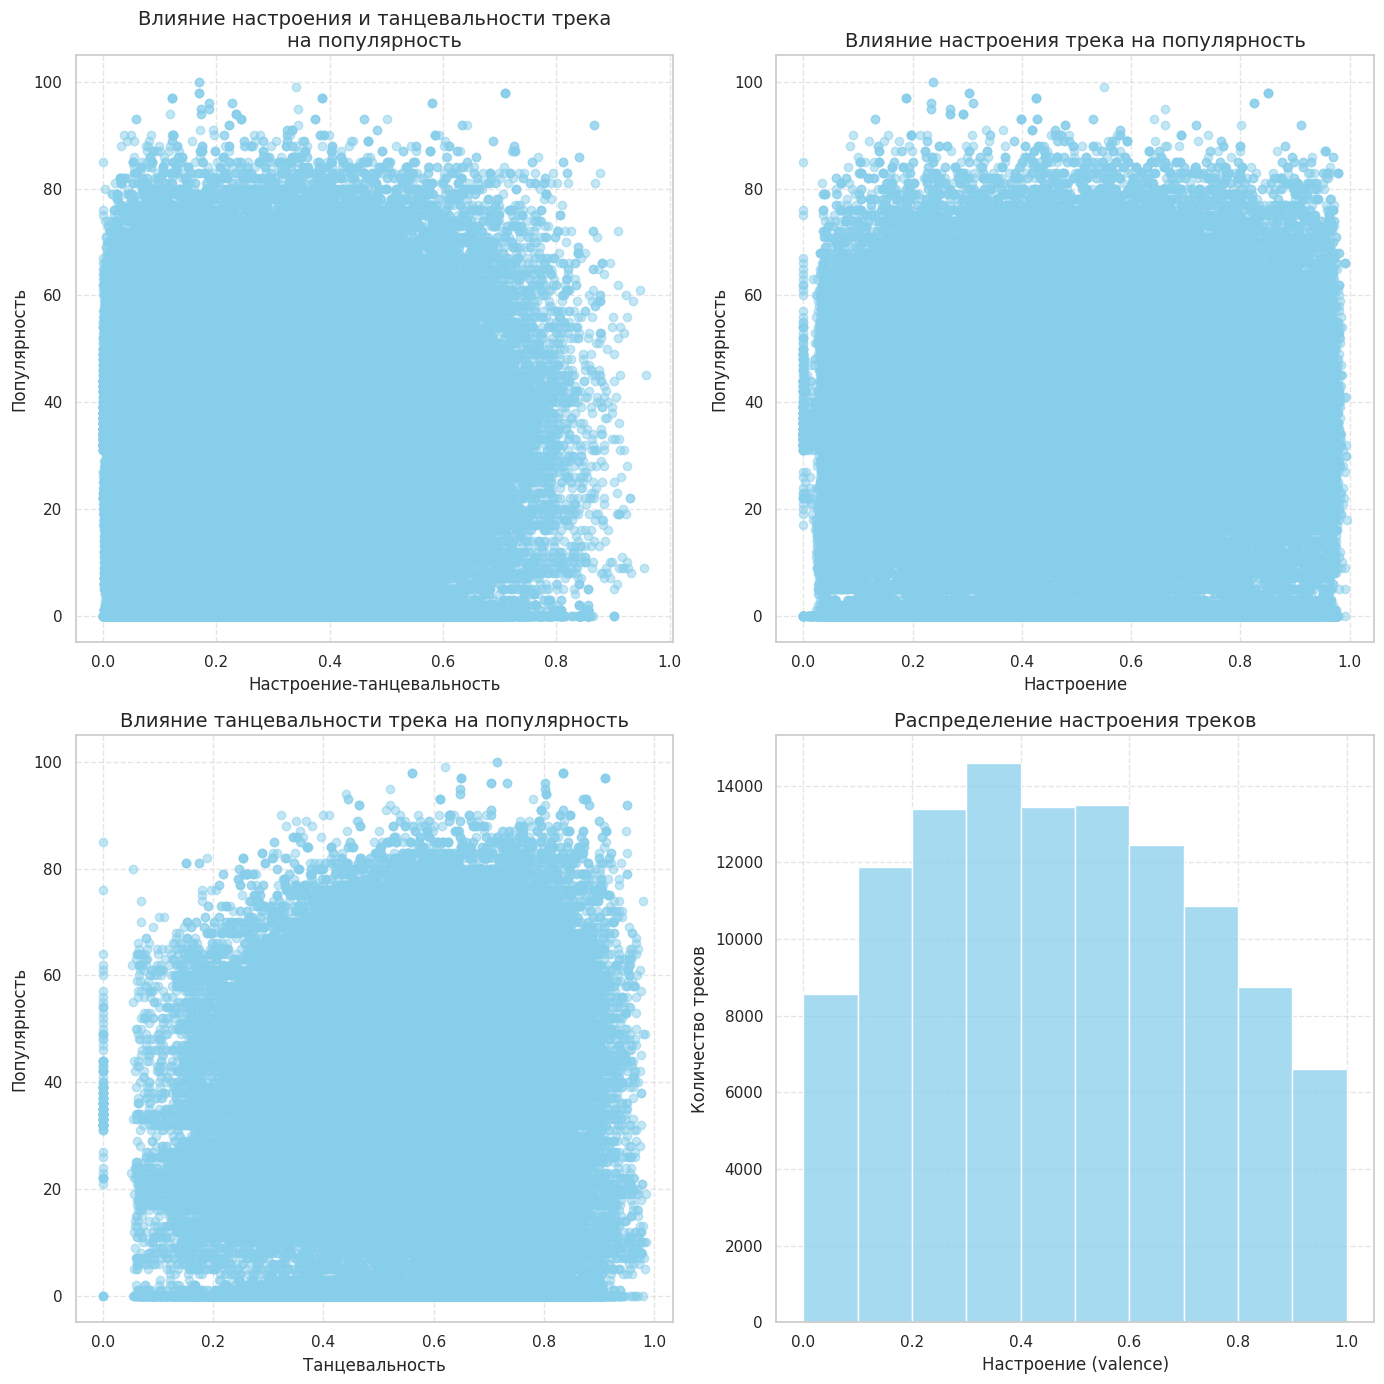

In [ ]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
plt.scatter(valence_dancebility, data['popularity'], alpha=0.5, c='skyblue')
plt.title("Влияние настроения и танцевальности трека\nна популярность", fontsize=14)
plt.xlabel("Настроение-танцевальность", fontsize=12)
plt.ylabel("Популярность", fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.subplot(2, 2, 2)
plt.scatter(data['valence'], data['popularity'], alpha=0.5, c='skyblue')
plt.title("Влияние настроения трека на популярность", fontsize=14)
plt.xlabel("Настроение", fontsize=12)
plt.ylabel("Популярность", fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.subplot(2, 2, 3)
plt.scatter(data['danceability'], data['popularity'], alpha=0.5, c='skyblue')
plt.title("Влияние танцевальности трека на популярность", fontsize=14)
plt.xlabel("Танцевальность", fontsize=12)
plt.ylabel("Популярность", fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.subplot(2, 2, 4)
sns.histplot(data=data_initial['valence'], bins=np.arange(0, 1.1, 0.1), color='skyblue')
plt.title('Распределение настроения треков', fontsize=14)
plt.xlabel('Настроение (valence)', fontsize=12)
plt.ylabel('Количество треков', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

1. Настроение трека не влияет на популярность, но есть выбросы, достигающие наивысшей популярности. Много треков с настроение (0.2; 0.6)
2. Чем трек танцевальнее, тем выше у него популярность. Наивысшие значения популярности достигаются при танцевальности выше 0.5
3. Совокупный признак "Настроение-танцевальность" показывает, что при значении 0.6 и выше показатель популярности снижается

Вывод:

Данный признак может быть полезен для модели, но он не является важнейшим

In [ ]:
valence_danceability_corr = data['popularity'].corr(valence_dancebility)
print(f'Корреляция между "Настроение-танцевальность" и популярностью: {valence_danceability_corr:.2f}')

Корреляция между "Настроение-танцевальность" и популярностью: -0.04


Корреляция между ***popularity*** и ***valence_danceability*** равна -0.04. Это говорит о том, что нет линейной зависимости между данными признаками

# Boxplot и распределение для числовых признаков

Решил сделать графики boxplot и на основе их вручную удалить выбросы. После нескольких тестов, я пришёл к выводу, что удаление выбросов, в моём случае, только ухудшало метрики. Поэтому решил не удалять выбросы.

Функция для отрисовки графиков

In [ ]:
def draw_boxplot_and_distribution(feature_name, feature_data):
  plt.figure(figsize=(14, 14))

  plt.subplot(3, 1, 1)
  sns.boxplot(x=feature_data)
  plt.title(f"Boxplot для признака {feature_name}")

  if feature_name != 'popularity':
    plt.subplot(3, 1, 2)
    plt.scatter(feature_data, data['popularity'], alpha=0.5)
    plt.title(f"Scatter Plot of {feature_name} vs Popularity")
    plt.xlabel(feature_name)
    plt.ylabel("Popularity")

  plt.tight_layout()
  plt.show()

  lower_quantile = feature_data.quantile(0.25)
  median = feature_data.quantile(0.5)
  upper_quantile = feature_data.quantile(0.75)

  print(f'Нижний квантиль (Q1): {round(lower_quantile, 2)}')
  print(f'Медиана (Q2): {round(median, 2)}')
  print(f'Верхний квантиль (Q3): {round(upper_quantile, 2)}')

In [ ]:
# outlier_indices = []

## Работа с длительностью треков

Переведём длительность треков из миллисекунд в минуты

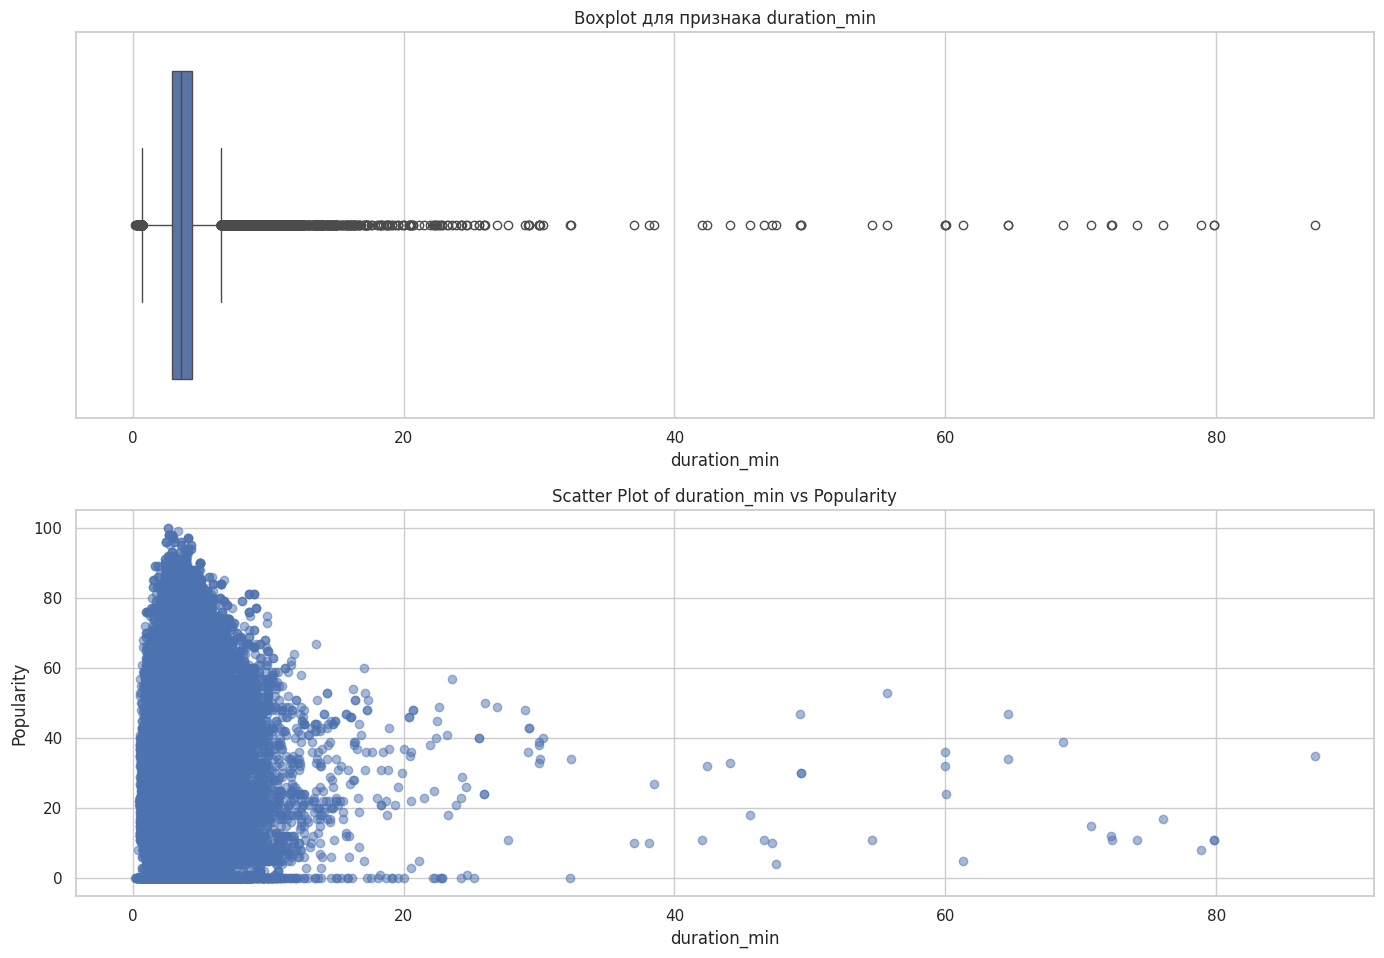

Нижний квантиль (Q1): 2.9
Медиана (Q2): 3.55
Верхний квантиль (Q3): 4.36


In [ ]:
data['duration_min'] = data['duration_ms'] / 60000
draw_boxplot_and_distribution('duration_min', data['duration_min'])

На графике Boxplot видно, что есть много выбросов. Значение в точке верхнего квантиля равно 4.36 минутам. Значение в точке нижнего квантиля равно 2.9 минутам. Медианное значение 3.55 минут

По графику распределения видно, что основная часть треков длительностью примерно до 13 минут

Удалим из датасета треки с длительностью более 18 минут

In [ ]:
# outlier_indices.extend(np.where(data['duration_min'] > 18.0)[0].tolist())

## Работа с танцевальностью треков

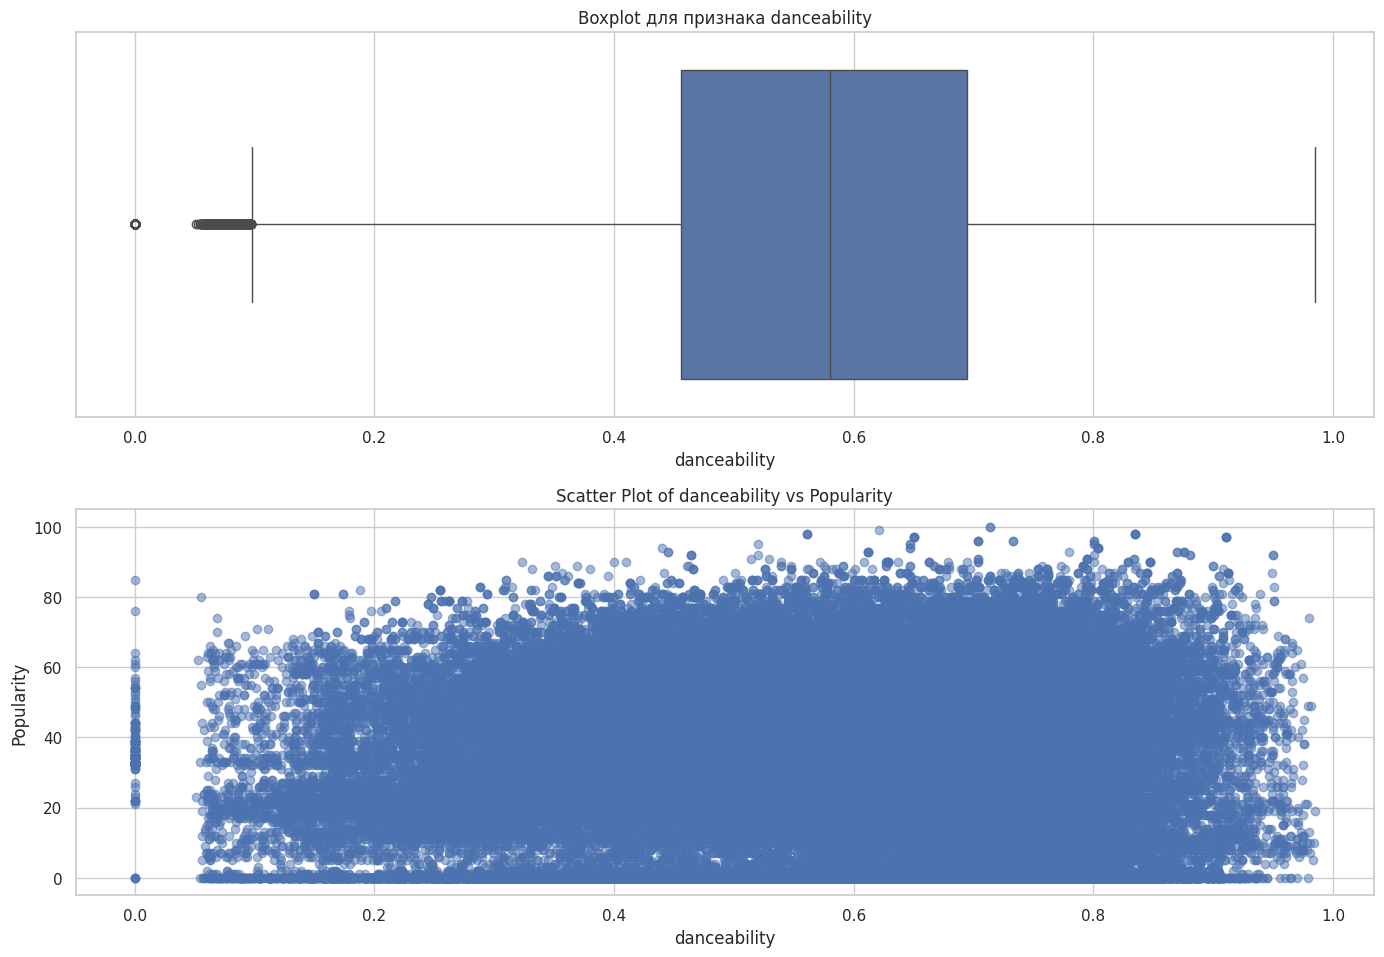

Нижний квантиль (Q1): 0.46
Медиана (Q2): 0.58
Верхний квантиль (Q3): 0.7


In [ ]:
draw_boxplot_and_distribution('danceability', data['danceability'])

На графике Boxplot видно, что есть выбросы, они находятся в диапазоне танцевальности примерно от 0 до 0.1. Значение верхнего квантиля равно 0.7, нижнего квантиля 0.46. Медиана примерно равна 0.58

На графике распределения видно, что основная часть треков имеет танцевальность в границах примерно от 0.17 до 0.9

Удалим из датасета треки с танцевальностью равной 0

In [ ]:
# outlier_indices.extend(np.where(data['danceability'] == 0)[0].tolist())

## Работа с энергичностью треков

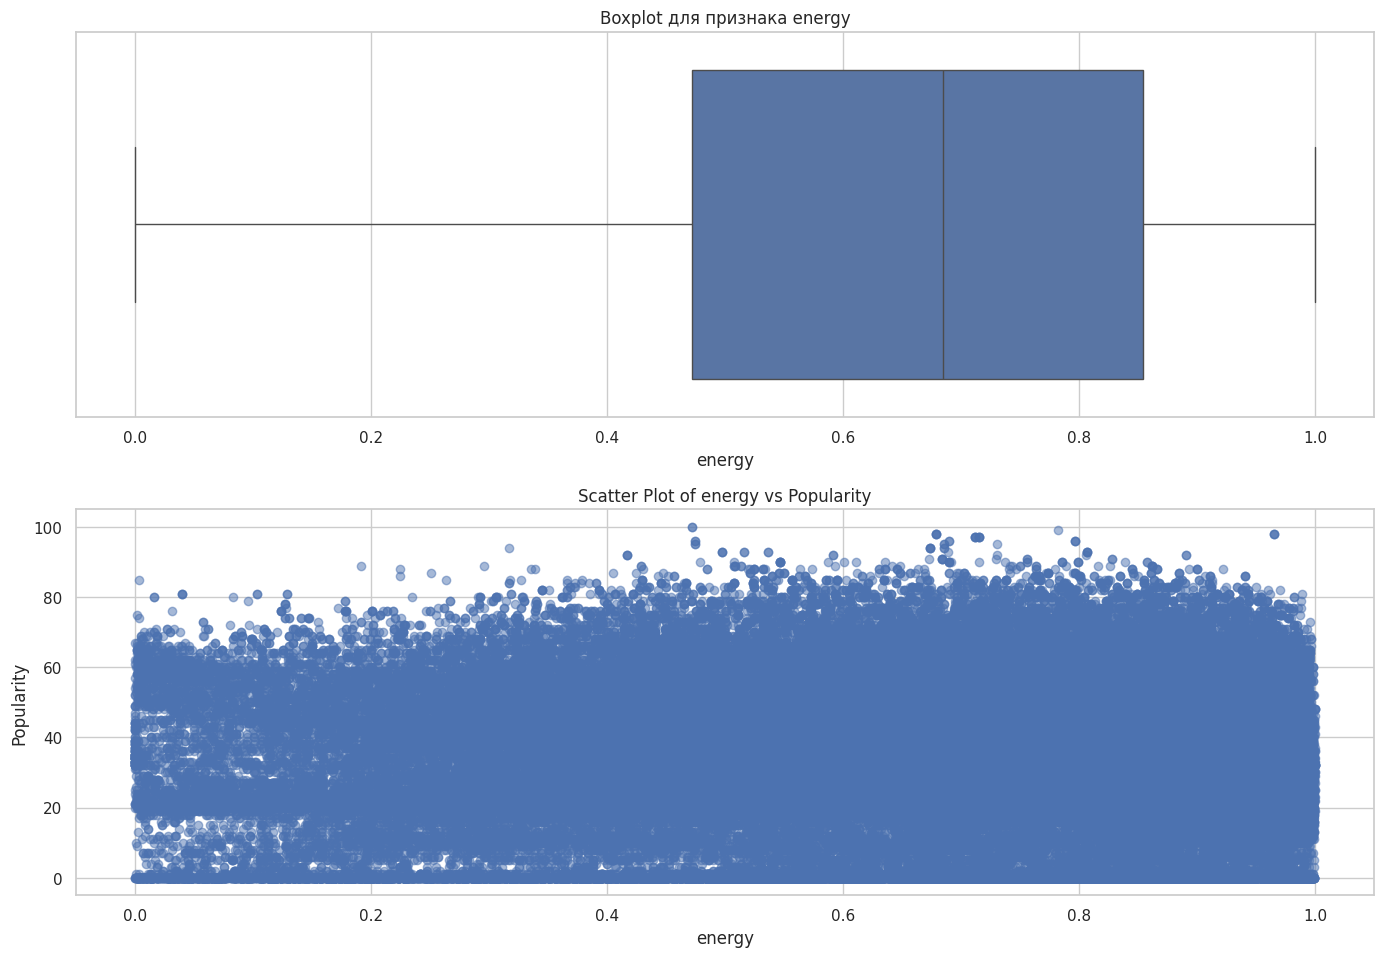

Нижний квантиль (Q1): 0.47
Медиана (Q2): 0.68
Верхний квантиль (Q3): 0.85


In [ ]:
draw_boxplot_and_distribution('energy', data['energy'])

На графике Boxplot видно, что нет выбросов. Верхний квантиль равен 0.85, нижний 0.47, медиана 0.68

На графике распределения видно, что треки впринципе распределены равномерно, но есть небольшие просадки при энергичности меньше 0.5

На основе этого признака никаких действий принимать не будем

## Работа с тональностью треков

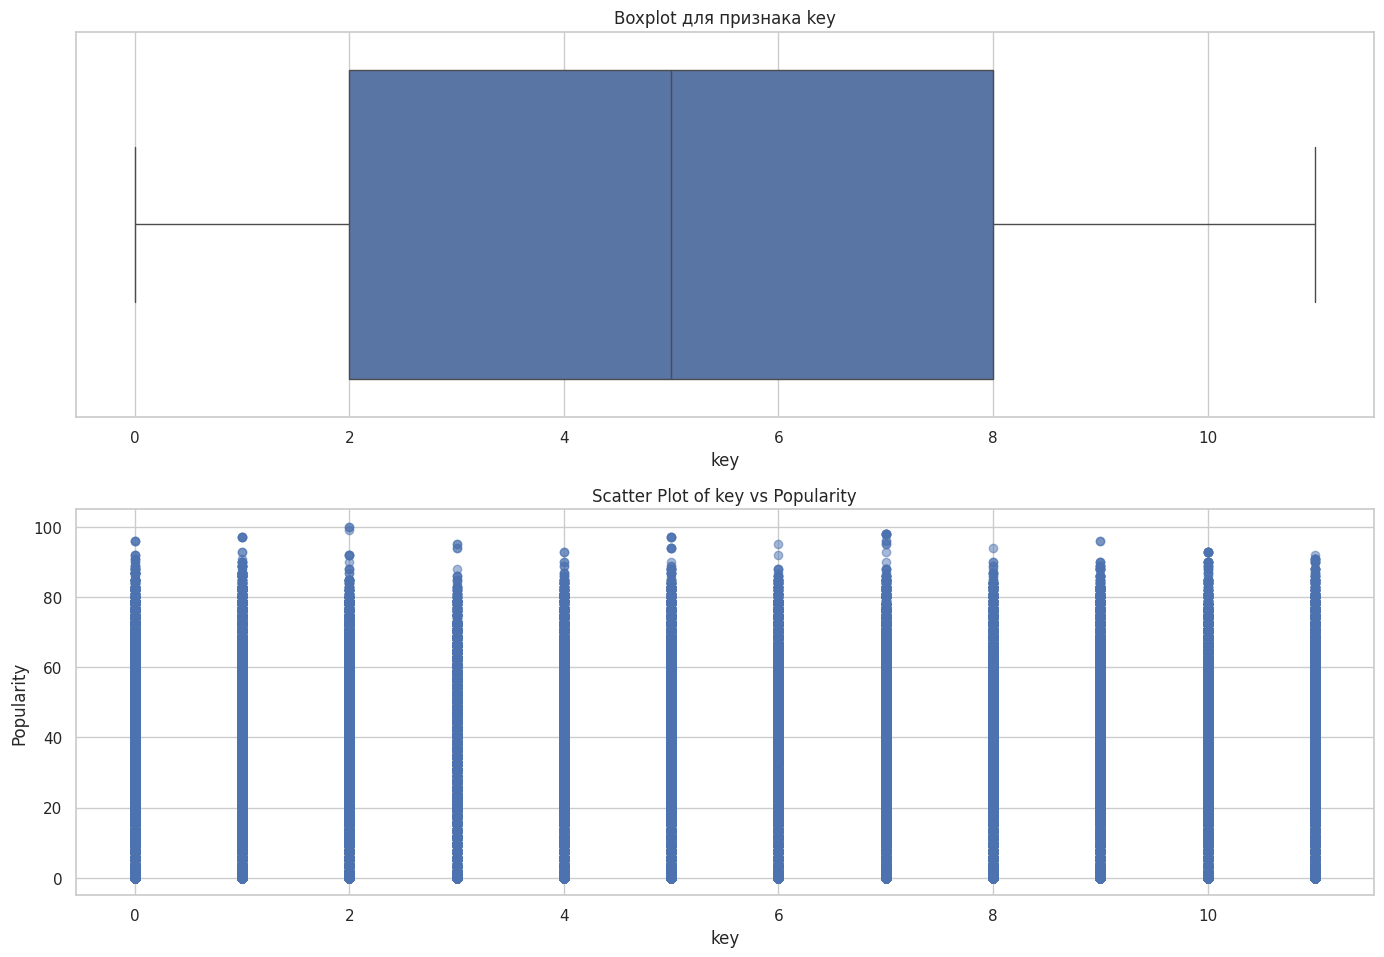

Нижний квантиль (Q1): 2.0
Медиана (Q2): 5.0
Верхний квантиль (Q3): 8.0


In [ ]:
draw_boxplot_and_distribution('key', data['key'])

На графиках видно, что данные распределены равномерно

На основе этого признака никаких действий принимать не будем

## Работа со средней громкостью треков

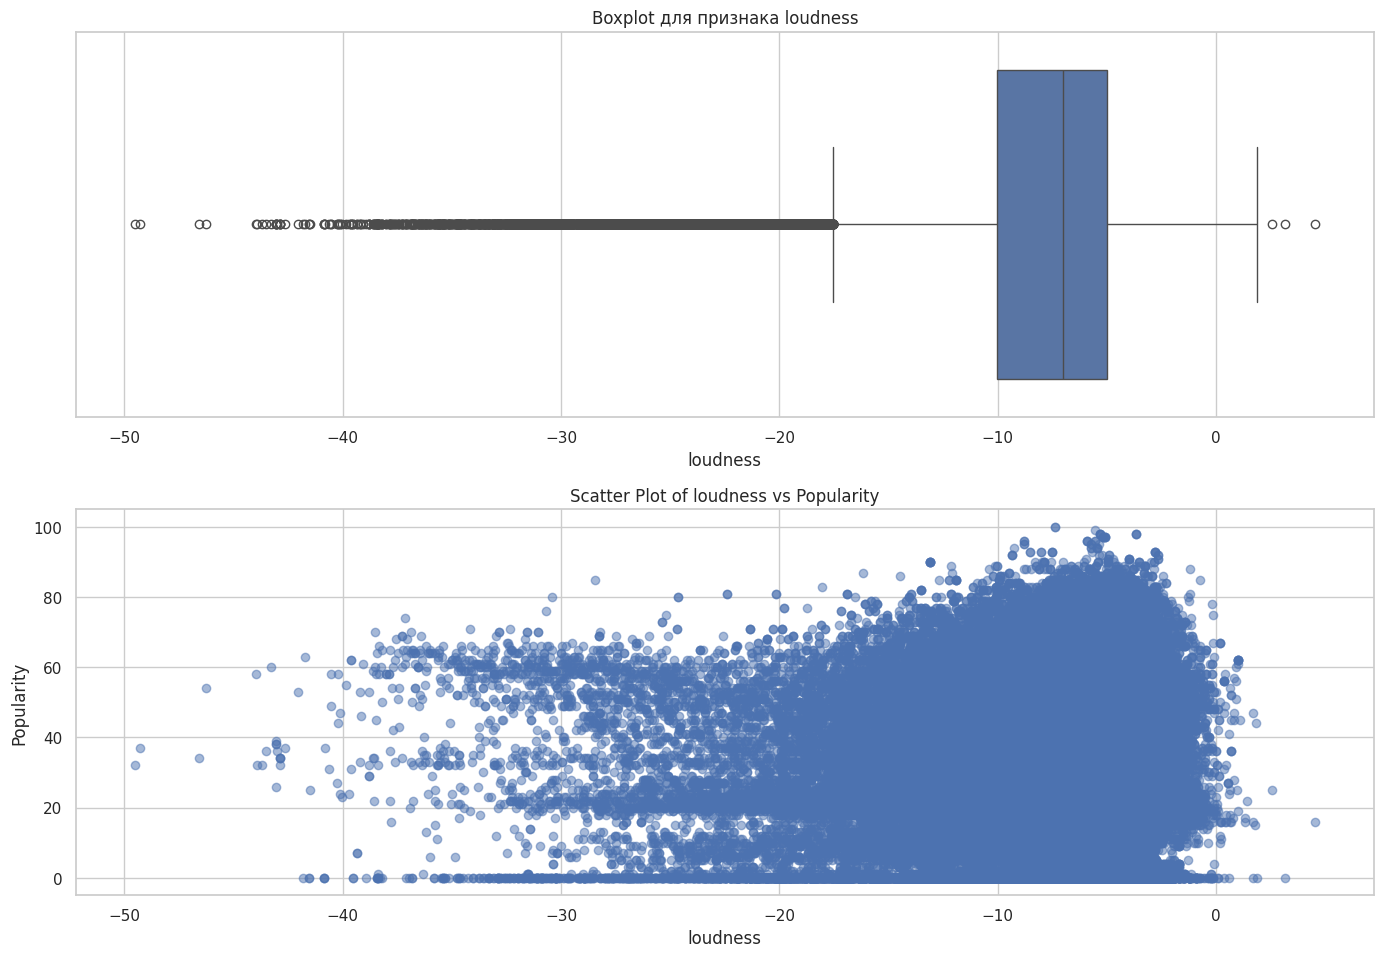

Нижний квантиль (Q1): -10.01
Медиана (Q2): -7.0
Верхний квантиль (Q3): -5.0


In [ ]:
draw_boxplot_and_distribution('loudness', data['loudness'])

На графике Boxplot видно, что много выбросов. Они, в основном, лежат в диапазоне примерно от -18 до -40. Верхний квантиль равен -5, нижний -10, медиана -7

На графике распределения видно, что основная часть треков имеет громкость в диапазоне от 0 до -20

In [ ]:
# outlier_indices.extend(np.where(data['loudness'] < -30)[0].tolist())

## Работа с режимом тональности трека (мажор, минор)

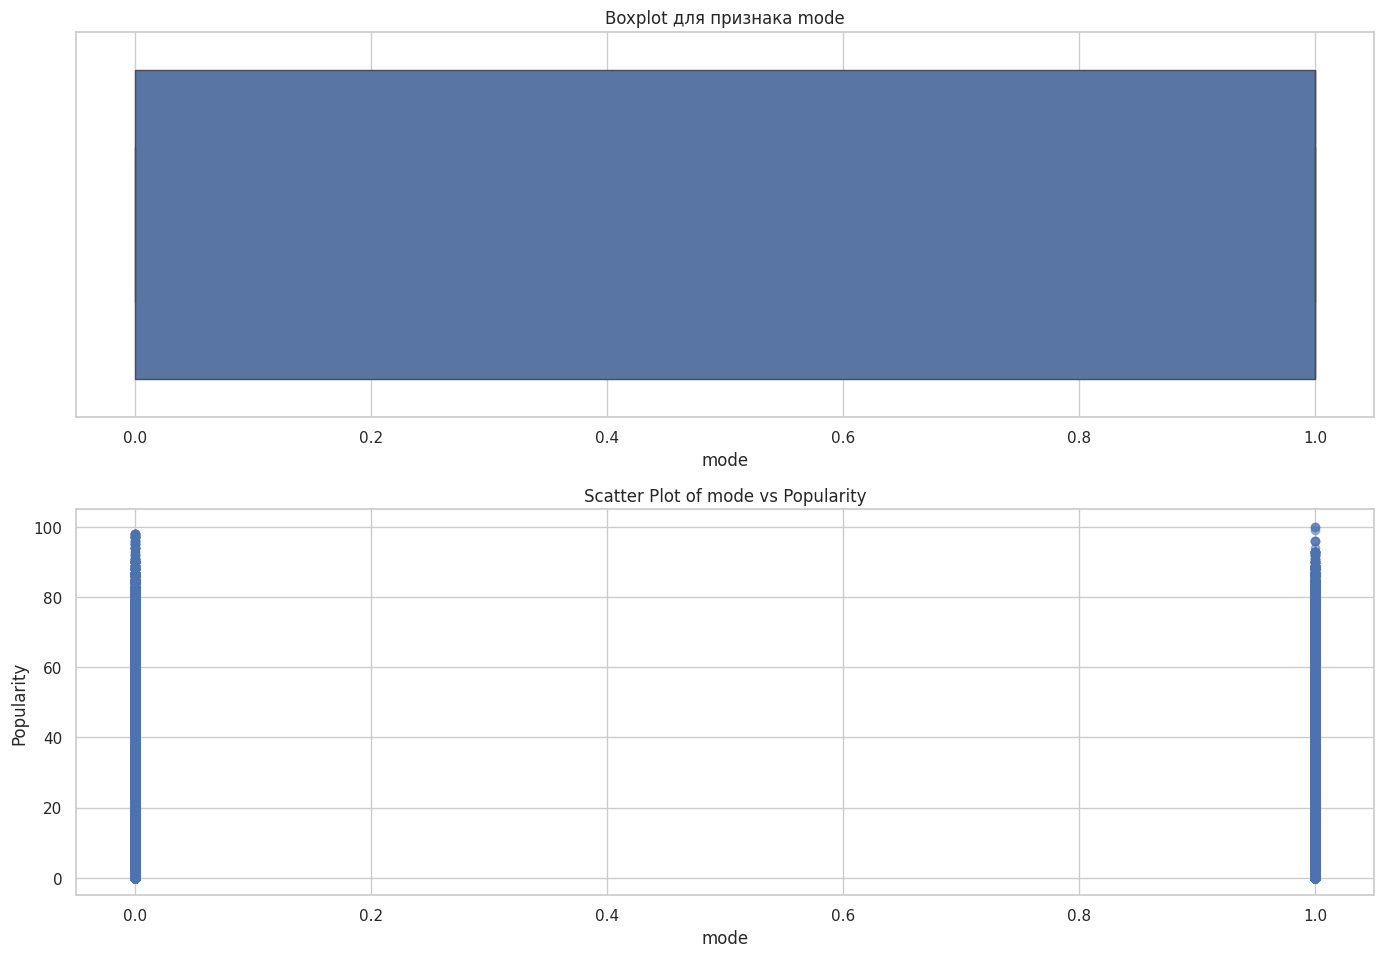

Нижний квантиль (Q1): 0.0
Медиана (Q2): 1.0
Верхний квантиль (Q3): 1.0


In [ ]:
draw_boxplot_and_distribution('mode', data['mode'])

По графикам видно, что распределение равномерное, выбросов нет. Верхний квантиль равен 1, нижний равен 0, медиана равна 1

На основе этого признака никаких действий принимать не будем

## Работа с показателем речего контента в треке

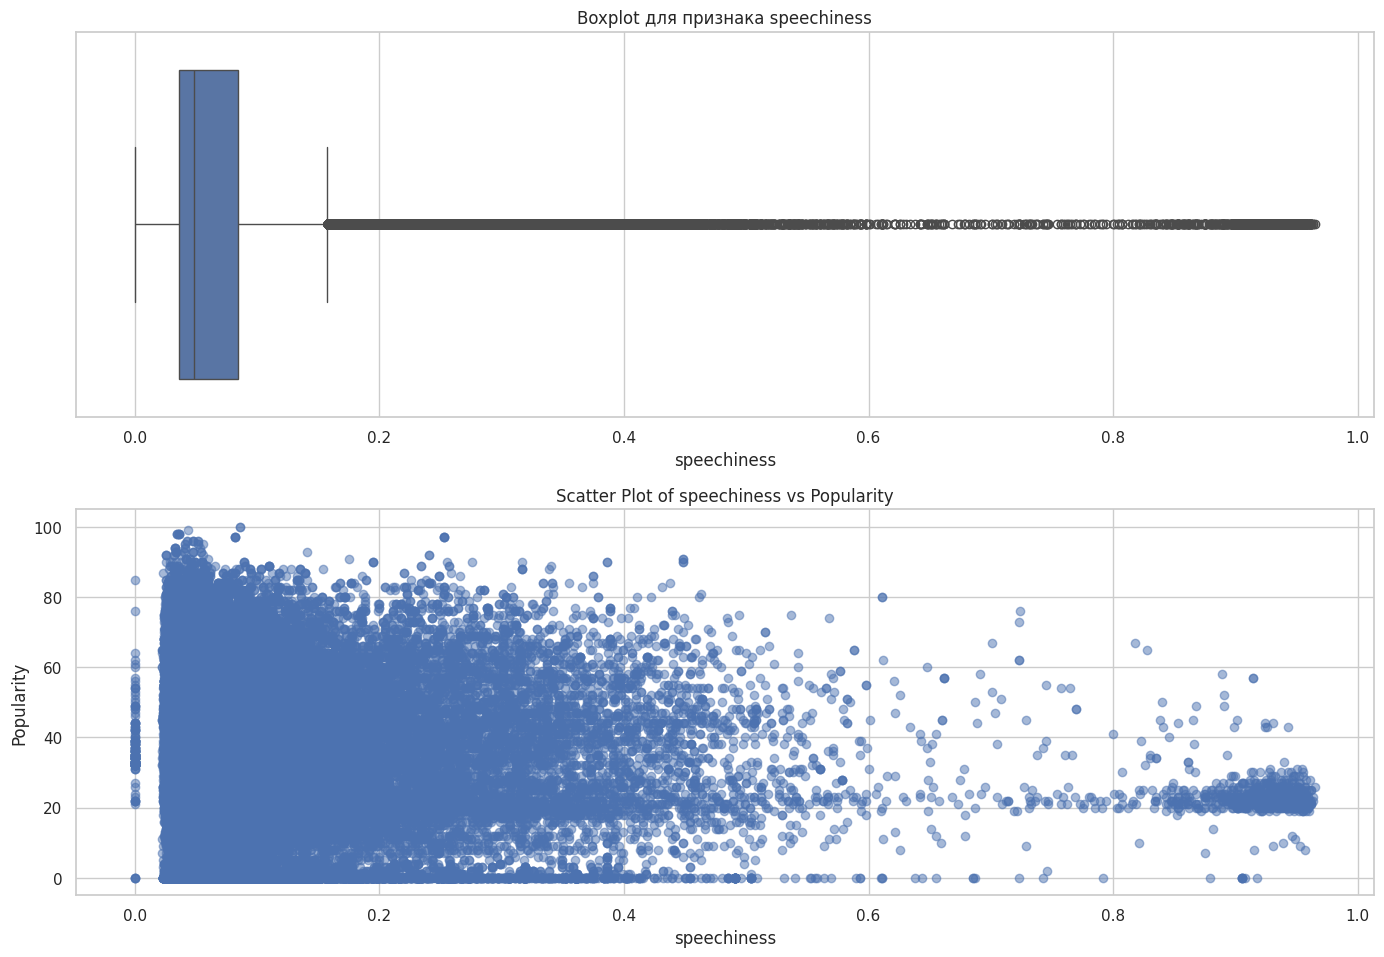

Нижний квантиль (Q1): 0.04
Медиана (Q2): 0.05
Верхний квантиль (Q3): 0.08


In [ ]:
draw_boxplot_and_distribution('speechiness', data['speechiness'])

На графике Boxplot видно, что очень много выбросов. Верхний квантиль равен 0.08, нижний 0.04, медиана 0.05

На графике распределения видно, что наиболее популярны треки с околонулевым *speechiness*. Основное количество треков - это треки с показателем *speechiness* до 0.4

Удалим из датасета треки со значением speechiness от 0.6 до 0.8

In [ ]:
# outlier_indices.extend(np.where((data['speechiness'] > 0.6) & (data['speechiness'] < 0.8))[0].tolist())

## Работа с акустичностью трека

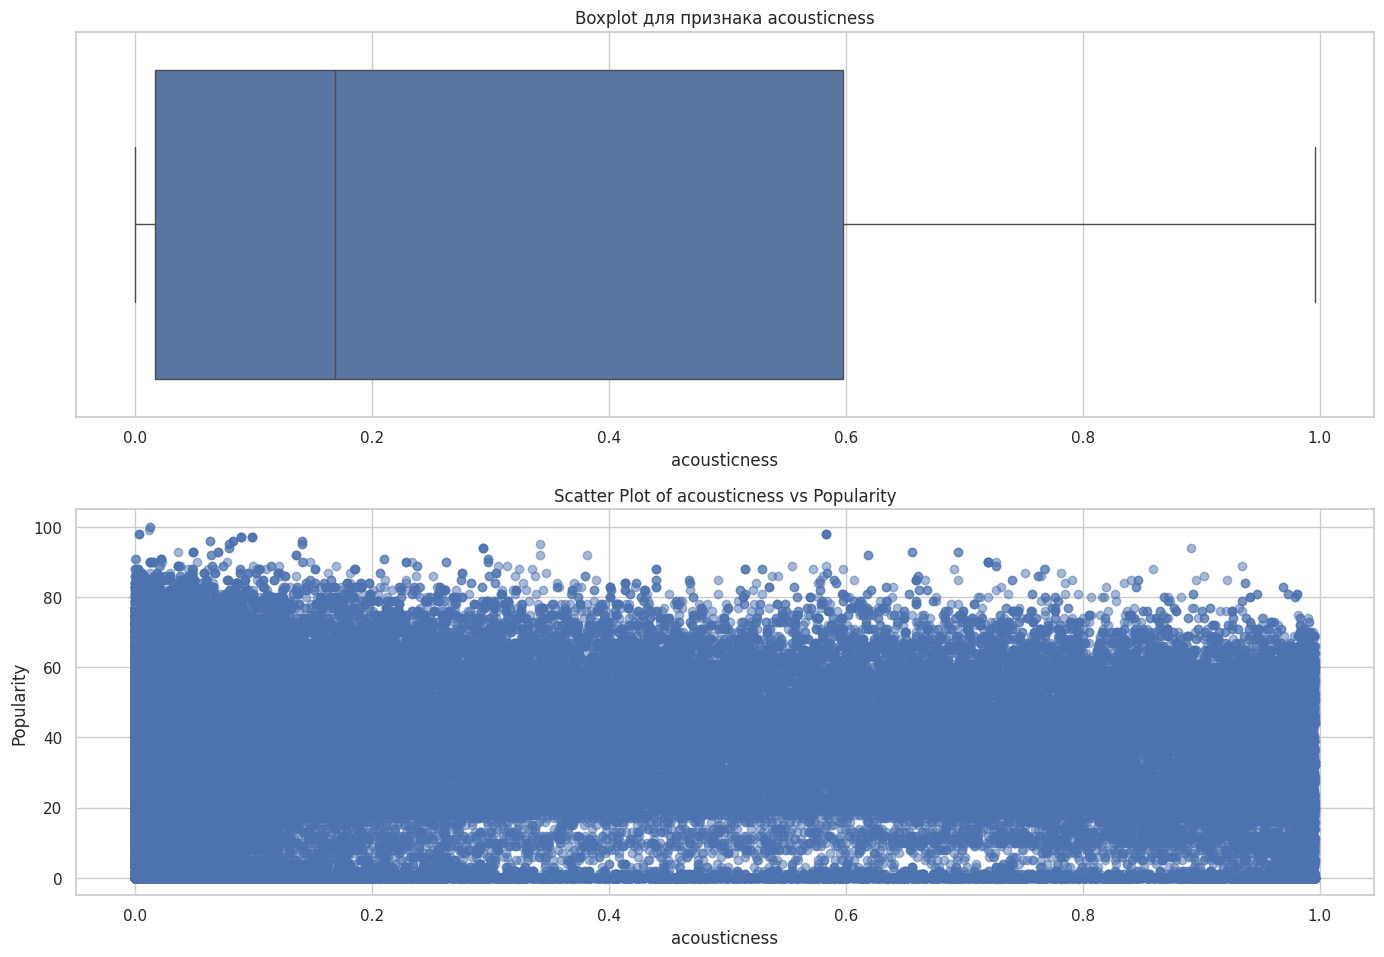

Нижний квантиль (Q1): 0.02
Медиана (Q2): 0.17
Верхний квантиль (Q3): 0.6


In [ ]:
draw_boxplot_and_distribution('acousticness', data['acousticness'])

На графиках видно, что распределение равномерное, выбросов нет. Верхний квантиль равен 0.6, нижний 0.02, медиана 0.17

На основе этого признака никаких действий принимать не будем

## Работа с показателем инструментальности трека

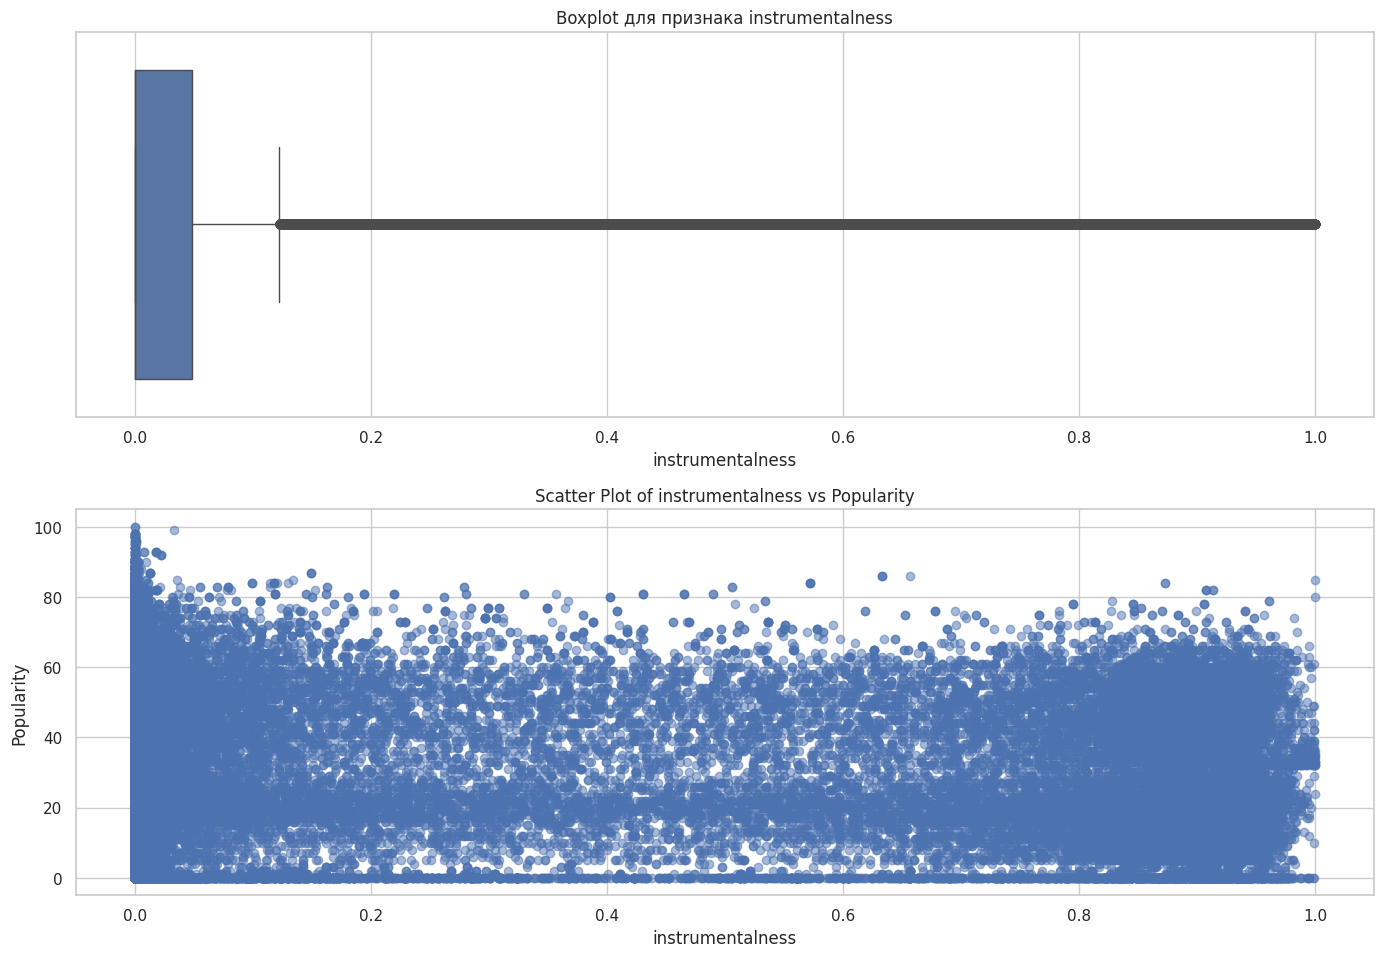

Нижний квантиль (Q1): 0.0
Медиана (Q2): 0.0
Верхний квантиль (Q3): 0.05


In [ ]:
draw_boxplot_and_distribution('instrumentalness', data['instrumentalness'])

In [ ]:
data['instrumentalness'].median()

4.16e-05

На графике мы видим большое количество выбросов. Это логично, так как медиана признака равна околонулевому числу, а 50% значений меньше медианы

Избавляться от выбросов не будем, так как, по графику распределения, достаточно большое количество треков распределены по всему дипазону значений признака *instrumentalness*

## Работа с показателем "живости" трека

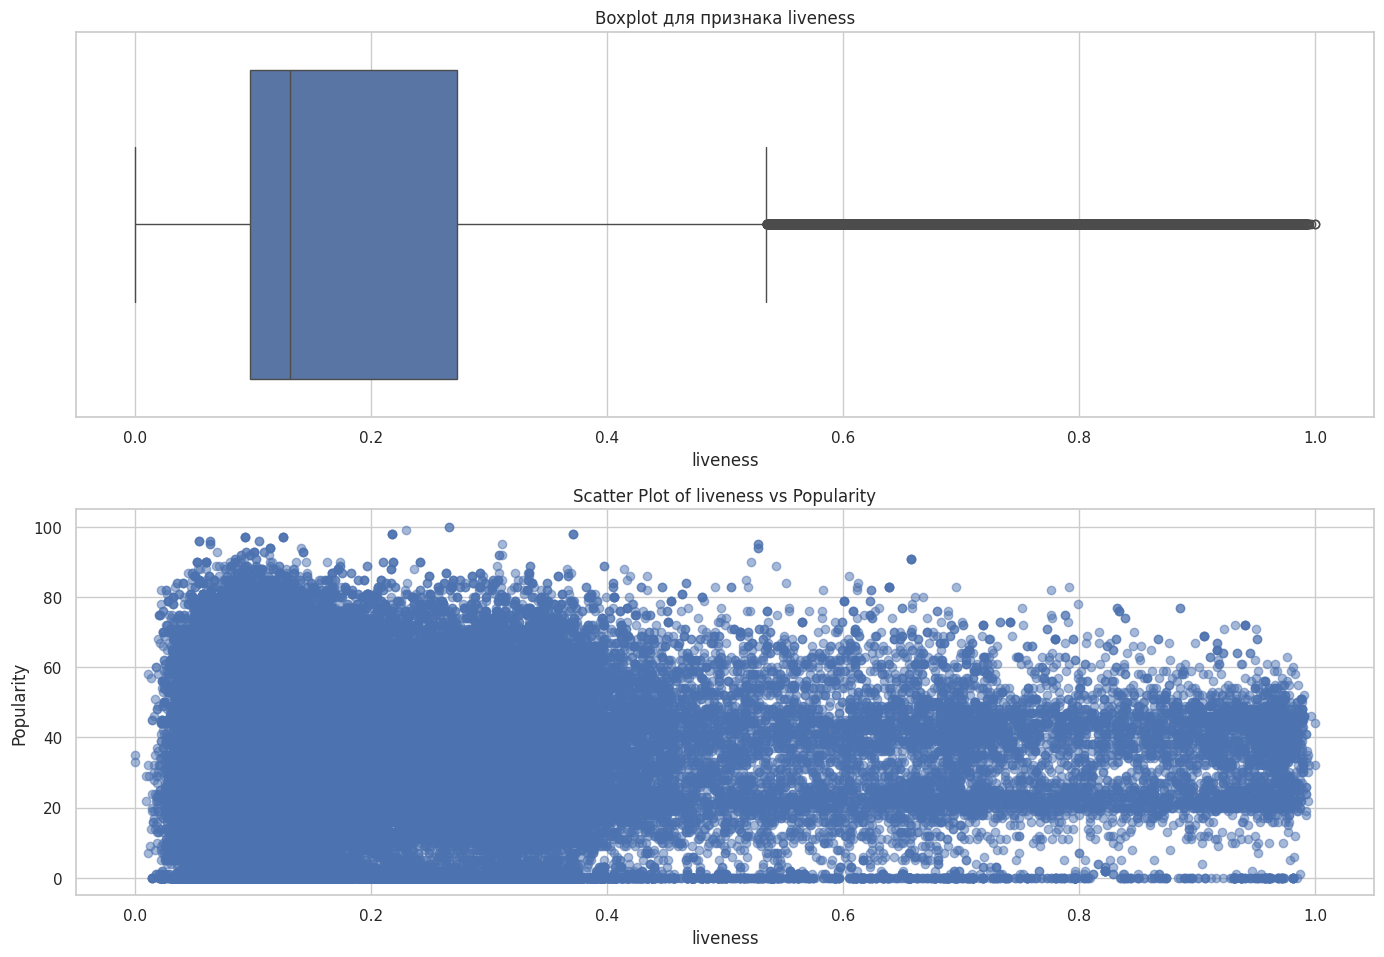

Нижний квантиль (Q1): 0.1
Медиана (Q2): 0.13
Верхний квантиль (Q3): 0.27


In [ ]:
draw_boxplot_and_distribution('liveness', data['liveness'])

По графику видно, что выбросов достаточно много. Более 50% значений меньше 0.13

Распределение треков неравномерное, но после значения *liveness* 0.5, треки распрелеяются примерно одинаково

Избавляться от выбросов этого признаке не будем

## Работа с настроением трека

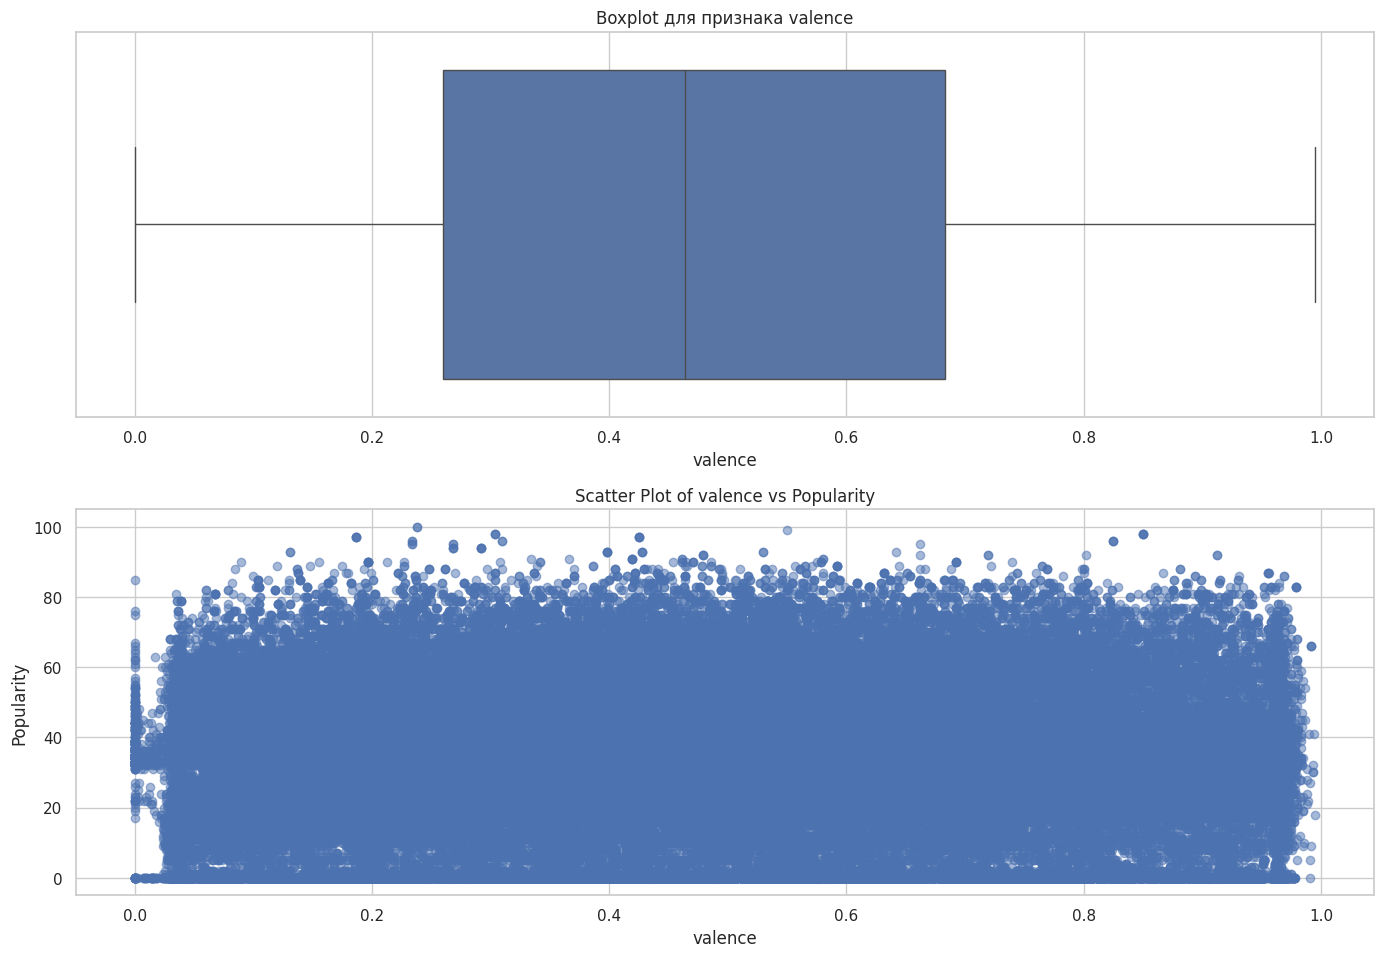

Нижний квантиль (Q1): 0.26
Медиана (Q2): 0.46
Верхний квантиль (Q3): 0.68


In [ ]:
draw_boxplot_and_distribution('valence', data['valence'])

На графиках видно, что выбросов нет и значения распределяются примерно одинаково

Никаких операций с данным признаком проводить не будем

## Работа с темпом трека

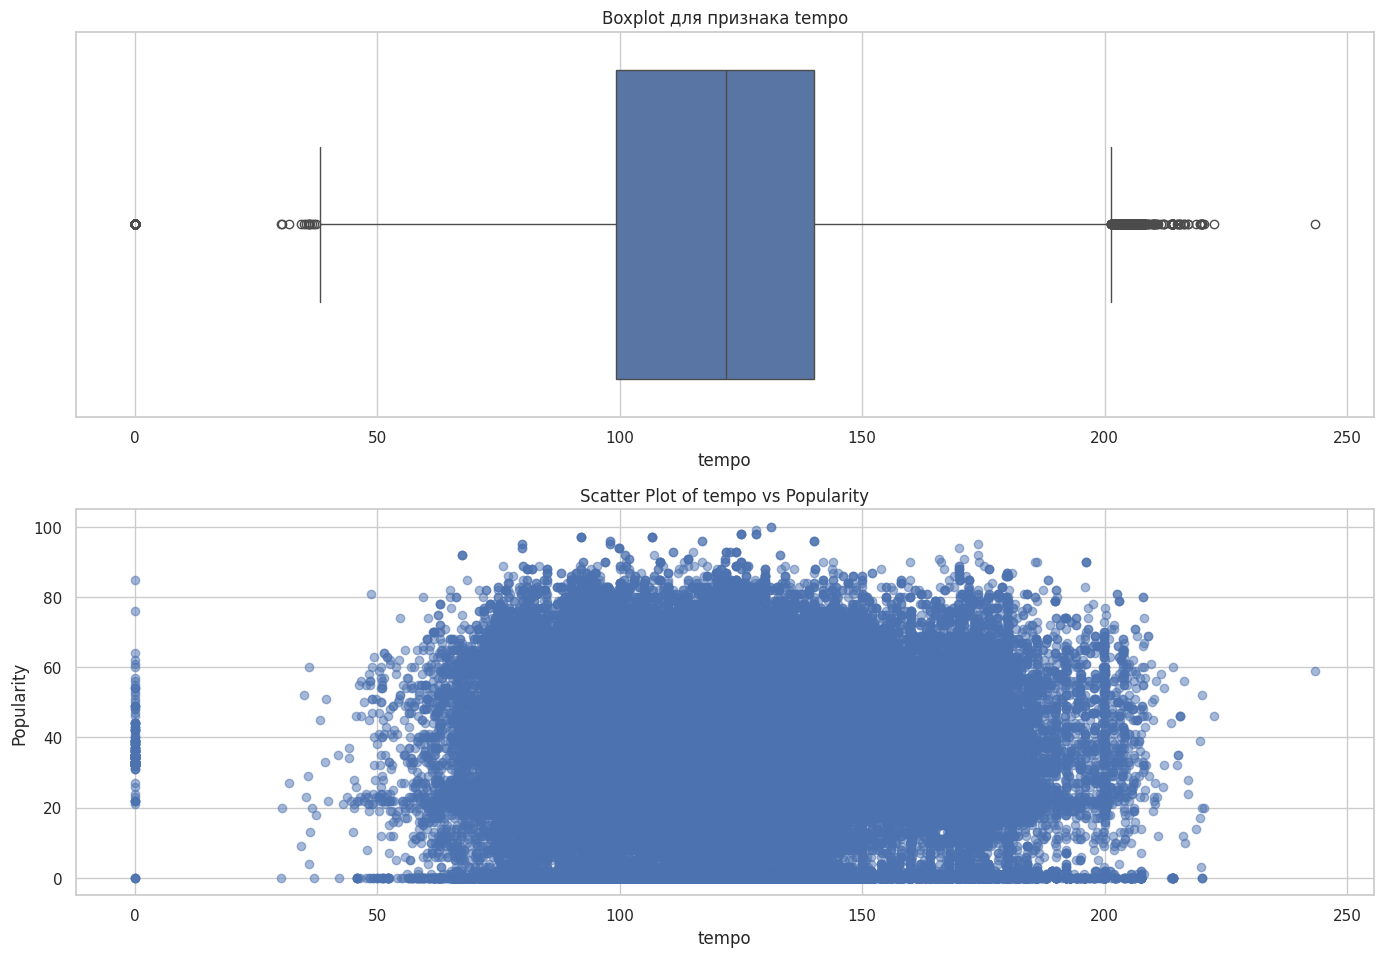

Нижний квантиль (Q1): 99.22
Медиана (Q2): 122.02
Верхний квантиль (Q3): 140.07


In [ ]:
draw_boxplot_and_distribution('tempo', data['tempo'])

На графике видны выбросы. Они имеют значения примерно меньше 37 и больше 202 ударов в минуту.

Основная доля треков лежит диапазоне значений признака *tempo* примерно от 75 до 180

Удалим треки с темпом меньше 38 и больше 205

In [ ]:
# outlier_indices.extend(np.where((data['tempo'] < 38) | (data['tempo'] > 205))[0].tolist())

## Работа с размерностью трека

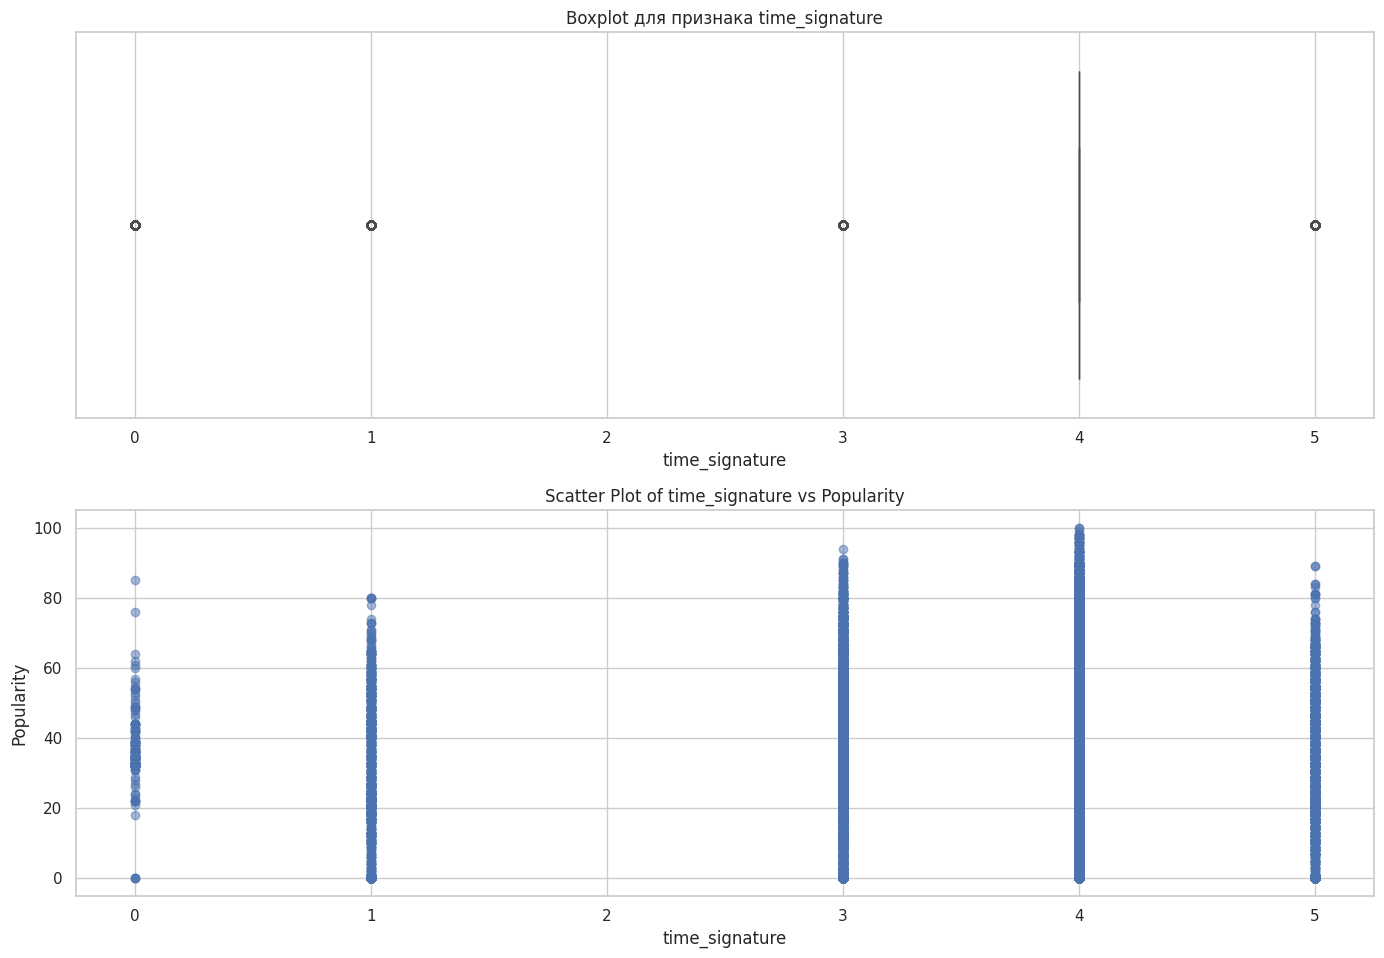

Нижний квантиль (Q1): 4.0
Медиана (Q2): 4.0
Верхний квантиль (Q3): 4.0


In [ ]:
draw_boxplot_and_distribution('time_signature', data['time_signature'])

Поскольку нет музыки с размерностью 0/4 и 1/4, то эти значения можно удалить

In [ ]:
# outlier_indices.extend(np.where(data['time_signature'] <= 1)[0].tolist())

## Удаление выбросов

In [ ]:
# len(outlier_indices)

In [ ]:
# outlier_indices = np.array(outlier_indices)
# outlier_indices = np.union1d(outlier_indices, outlier_indices)
# outlier_indices

In [ ]:
# outlier_indices = outlier_indices.tolist()
# outlier_indices

In [ ]:
# print(f'Размер датасета до удаления: {data.shape}')
# data = data.drop(outlier_indices)
# print(f'Размер датасета после удаления: {data.shape}')

# Создание новых признаков

## Преобразование duration_min в One Hot Encoding

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artists           113999 non-null  int64  
 1   album_name        113999 non-null  int64  
 2   track_name        113999 non-null  int64  
 3   popularity        113999 non-null  int64  
 4   duration_ms       113999 non-null  int64  
 5   explicit          113999 non-null  bool   
 6   danceability      113999 non-null  float64
 7   energy            113999 non-null  float64
 8   key               113999 non-null  int64  
 9   loudness          113999 non-null  float64
 10  mode              113999 non-null  int64  
 11  speechiness       113999 non-null  float64
 12  acousticness      113999 non-null  float64
 13  instrumentalness  113999 non-null  float64
 14  liveness          113999 non-null  float64
 15  valence           113999 non-null  float64
 16  tempo             113999 

In [ ]:
import math
duration_min = data['duration_ms'] / 60000
max_duration = duration_min.max()

bins = [0, 1, 2, 3, 4, 5, 10, max_duration]
labels = ['0-1 min', '1-2 min', '2-3 min', '3-4 min', '4-5 min', '5-10 min', '10+ min']

duration_category = pd.cut(duration_min, bins=bins, labels=labels, include_lowest=True)

Закодирую длительность трека с помощью One Hot Encoding

In [ ]:
duration_dummies = pd.get_dummies(duration_category, prefix='duration')

data = pd.concat([data, duration_dummies], axis=1)
data = data.drop('duration_ms', axis=1)

In [ ]:
data.iloc[0]

artists                 10357
album_name               8100
track_name              11741
popularity                 73
explicit                False
danceability            0.676
energy                  0.461
key                         1
loudness               -6.746
mode                        0
speechiness             0.143
acousticness           0.0322
instrumentalness     0.000001
liveness                0.358
valence                 0.715
tempo                  87.917
time_signature              4
track_genre                 0
duration_min         3.844433
duration_0-1 min        False
duration_1-2 min        False
duration_2-3 min        False
duration_3-4 min         True
duration_4-5 min        False
duration_5-10 min       False
duration_10+ min        False
Name: 0, dtype: object

## Создание признака "Настроение-танцевальность"

In [ ]:
data['valence_dancebility'] = data['valence'] * data['danceability']

## Создание признака "Энергичность-танцевальность"

In [ ]:
data['energy_danceabilty'] = data['energy'] * data['danceability']

## Создание признака "Громкость-энергичность"

In [ ]:
data['loudness_energy'] = data['loudness'] * data['energy']

## Разбиение темпа трека на категории

In [ ]:
bins = [0, 40, 80, 120, 160, data['tempo'].max()]
labels = ['0-40 bpm', '40-80 bpm', '80-120 bpm', '120-160 bpm', '160+ npm']

tempo_category = pd.cut(data['tempo'], bins=bins, labels=labels, include_lowest=True)

In [ ]:
duration_dummies = pd.get_dummies(tempo_category, prefix='tempo')

data = pd.concat([data, duration_dummies], axis=1)
data = data.drop('tempo', axis=1)

# Преобразование bool признаков в числовые

Для преобразования буду использовать LabelEncoder

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   artists              113999 non-null  int64  
 1   album_name           113999 non-null  int64  
 2   track_name           113999 non-null  int64  
 3   popularity           113999 non-null  int64  
 4   explicit             113999 non-null  bool   
 5   danceability         113999 non-null  float64
 6   energy               113999 non-null  float64
 7   key                  113999 non-null  int64  
 8   loudness             113999 non-null  float64
 9   mode                 113999 non-null  int64  
 10  speechiness          113999 non-null  float64
 11  acousticness         113999 non-null  float64
 12  instrumentalness     113999 non-null  float64
 13  liveness             113999 non-null  float64
 14  valence              113999 non-null  float64
 15  time_signature       1

In [ ]:
boolean_features = data.select_dtypes(include=['bool']).columns.tolist()

In [ ]:
boolean_features

['explicit',
 'duration_0-1 min',
 'duration_1-2 min',
 'duration_2-3 min',
 'duration_3-4 min',
 'duration_4-5 min',
 'duration_5-10 min',
 'duration_10+ min',
 'tempo_0-40 bpm',
 'tempo_40-80 bpm',
 'tempo_80-120 bpm',
 'tempo_120-160 bpm',
 'tempo_160+ npm']

In [ ]:
boolean_cols = data.select_dtypes(include=['bool']).columns

In [ ]:
for col in boolean_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   artists              113999 non-null  int64  
 1   album_name           113999 non-null  int64  
 2   track_name           113999 non-null  int64  
 3   popularity           113999 non-null  int64  
 4   explicit             113999 non-null  int64  
 5   danceability         113999 non-null  float64
 6   energy               113999 non-null  float64
 7   key                  113999 non-null  int64  
 8   loudness             113999 non-null  float64
 9   mode                 113999 non-null  int64  
 10  speechiness          113999 non-null  float64
 11  acousticness         113999 non-null  float64
 12  instrumentalness     113999 non-null  float64
 13  liveness             113999 non-null  float64
 14  valence              113999 non-null  float64
 15  time_signature       1

In [ ]:
data.iloc[0]

artists                10357.000000
album_name              8100.000000
track_name             11741.000000
popularity                73.000000
explicit                   0.000000
danceability               0.676000
energy                     0.461000
key                        1.000000
loudness                  -6.746000
mode                       0.000000
speechiness                0.143000
acousticness               0.032200
instrumentalness           0.000001
liveness                   0.358000
valence                    0.715000
time_signature             4.000000
track_genre                0.000000
duration_min               3.844433
duration_0-1 min           0.000000
duration_1-2 min           0.000000
duration_2-3 min           0.000000
duration_3-4 min           1.000000
duration_4-5 min           0.000000
duration_5-10 min          0.000000
duration_10+ min           0.000000
valence_dancebility        0.483340
energy_danceabilty         0.311636
loudness_energy           -3.109906
tempo_0-40 bpm             0.000000
tempo_40-80 bpm            0.000000
tempo_80-120 bpm           1.000000
tempo_120-160 bpm          0.000000
tempo_160+ npm             0.000000
Name: 0, dtype: float64

# Корреляция новых признаков с популярностью

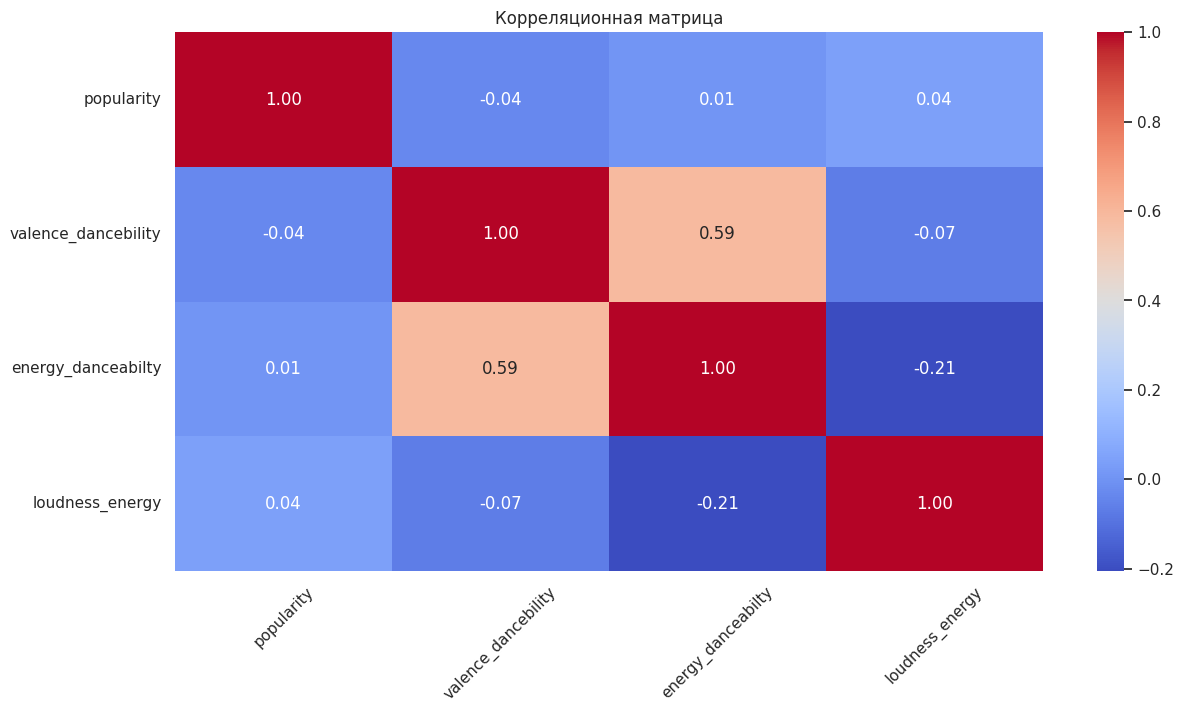

In [ ]:
features = ['popularity', 'valence_dancebility', 'energy_danceabilty', 'loudness_energy']

corr_matrix = data[features].corr()
plt.figure(figsize=(14, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляционная матрица")
plt.xticks(rotation=45)
plt.show()

1. На корреляционной матрице видно, что достаточно большая положительная корреляция (0.59) у признаков *valence_danceability* и *energy_danceabilty*. Эта корреляция вызвана тем, что в признаках присутствует один и тот же признак *danceability*. Кроме того, такая связь логична, поскольку танцевальность, энергичность и эмоциональная окраска трека (настроение) часто взаимосвязаны.

2. С целевой переменной "Популярность" ни один новый признак не коррелирует

# Разбиение датасета на тренировочный и тестовый наборы

In [ ]:
# Разделение данных на обучающую и тестовую выборки
# X = data.drop(columns=['popularity', 'track_id', 'valence', 'time_signature', 'Unnamed: 0'])  # измените на ваш целевой признак, если необходимо
X = data.drop(columns=['popularity', 'valence', 'time_signature',
                       'key', 'mode', 'liveness', 'duration_min', 'energy'])
y = data['popularity']  # измените на ваш целевой признак, если необходимо
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   artists              113999 non-null  int64  
 1   album_name           113999 non-null  int64  
 2   track_name           113999 non-null  int64  
 3   explicit             113999 non-null  int64  
 4   danceability         113999 non-null  float64
 5   loudness             113999 non-null  float64
 6   speechiness          113999 non-null  float64
 7   acousticness         113999 non-null  float64
 8   instrumentalness     113999 non-null  float64
 9   track_genre          113999 non-null  int64  
 10  duration_0-1 min     113999 non-null  int64  
 11  duration_1-2 min     113999 non-null  int64  
 12  duration_2-3 min     113999 non-null  int64  
 13  duration_3-4 min     113999 non-null  int64  
 14  duration_4-5 min     113999 non-null  int64  
 15  duration_5-10 min    1

In [ ]:
data.isnull().sum()

artists                0
album_name             0
track_name             0
popularity             0
explicit               0
danceability           0
energy                 0
key                    0
loudness               0
mode                   0
speechiness            0
acousticness           0
instrumentalness       0
liveness               0
valence                0
time_signature         0
track_genre            0
duration_min           0
duration_0-1 min       0
duration_1-2 min       0
duration_2-3 min       0
duration_3-4 min       0
duration_4-5 min       0
duration_5-10 min      0
duration_10+ min       0
valence_dancebility    0
energy_danceabilty     0
loudness_energy        0
tempo_0-40 bpm         0
tempo_40-80 bpm        0
tempo_80-120 bpm       0
tempo_120-160 bpm      0
tempo_160+ npm         0
dtype: int64

In [ ]:
data = data.dropna()

In [ ]:
data.isnull().sum()

artists                0
album_name             0
track_name             0
popularity             0
explicit               0
danceability           0
energy                 0
key                    0
loudness               0
mode                   0
speechiness            0
acousticness           0
instrumentalness       0
liveness               0
valence                0
time_signature         0
track_genre            0
duration_min           0
duration_0-1 min       0
duration_1-2 min       0
duration_2-3 min       0
duration_3-4 min       0
duration_4-5 min       0
duration_5-10 min      0
duration_10+ min       0
valence_dancebility    0
energy_danceabilty     0
loudness_energy        0
tempo_0-40 bpm         0
tempo_40-80 bpm        0
tempo_80-120 bpm       0
tempo_120-160 bpm      0
tempo_160+ npm         0
dtype: int64

In [ ]:
data

artists  album_name  track_name  popularity  explicit  danceability  \
0         10357        8100       11741          73         0         0.676   
1          3287       14796       22528          55         0         0.420   
2         12397       39162       60774          57         0         0.438   
3         14839        8580        9580          71         0         0.266   
4          5255       16899       25689          82         0         0.618   
...         ...         ...         ...         ...       ...           ...   
113995    22486          66       53329          21         0         0.172   
113996    22486          66       65090          22         0         0.174   
113997     4952        5028       38207          22         0         0.629   
113998    18534        7238       21507          41         0         0.587   
113999     4952       24357        5999          22         0         0.526   

        energy  key  loudness  mode  ...  duration_5-10 min  duration_10+ min  \
0       0.4610    1    -6.746     0  ...                  0                 0   
1       0.1660    1   -17.235     1  ...                  0                 0   
2       0.3590    0    -9.734     1  ...                  0                 0   
3       0.0596    0   -18.515     1  ...                  0                 0   
4       0.4430    2    -9.681     1  ...                  0                 0   
...        ...  ...       ...   ...  ...                ...               ...   
113995  0.2350    5   -16.393     1  ...                  1                 0   
113996  0.1170    0   -18.318     0  ...                  1                 0   
113997  0.3290    0   -10.895     0  ...                  0                 0   
113998  0.5060    7   -10.889     1  ...                  0                 0   
113999  0.4870    1   -10.204     0  ...                  0                 0   

        valence_dancebility  energy_danceabilty  loudness_energy  \
0                  0.483340            0.311636        -3.109906   
1                  0.112140            0.069720        -2.861010   
2                  0.052560            0.157242        -3.494506   
3                  0.038038            0.015854        -1.103494   
4                  0.103206            0.273774        -4.288683   
...                     ...                 ...              ...   
113995             0.005831            0.040420        -3.852355   
113996             0.006090            0.020358        -2.143206   
113997             0.467347            0.206941        -3.584455   
113998             0.242431            0.297022        -5.509834   
113999             0.372408            0.256162        -4.969348   

        tempo_0-40 bpm  tempo_40-80 bpm  tempo_80-120 bpm  tempo_120-160 bpm  \
0                    0                0                 1                  0   
1                    0                1                 0                  0   
2                    0                1                 0                  0   
3                    0                0                 0                  0   
4                    0                0                 1                  0   
...                ...              ...               ...                ...   
113995               0                0                 0                  1   
113996               0                0                 1                  0   
113997               0                0                 0                  1   
113998               0                0                 0                  1   
113999               0                1                 0                  0   

        tempo_160+ npm  
0                    0  
1                    0  
2                    0  
3                    1  
4                    0  
...                ...  
113995               0  
113996               0  
113997               0  
113998               0  
113999               0  

[113999

# Обучение

In [ ]:
!pip install scikeras

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import cross_validate
from scikeras.wrappers import KerasRegressor

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Функция для расчёта кросс-валидации и печати результатов

In [ ]:
def calculate_cross_validate(model):
    scoring = {
      'mse': 'neg_mean_squared_error',
      'r2': 'r2'
    }

    results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)

    return results

def print_cross_validate(results):
    mse = -results['test_mse']
    r2 = results['test_r2']

    print("Средний MSE:", round(mse.mean(), 2))
    print("Лучший MSE:", round(mse.min(), 2))
    print()
    print("Средний R^2:", round(r2.mean(), 2))
    print("Лучший R^2:", round(r2.max(), 2))


## Модель 1

In [ ]:
# Build the model
def create_model1():
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = create_model1()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,889 (23.00 KB)

 Trainable params: 5,889 (23.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 612.3411 - val_loss: 467.3121
Epoch 2/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 461.8130 - val_loss: 461.8030
Epoch 3/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 451.1927 - val_loss: 457.6443
Epoch 4/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 446.8474 - val_loss: 457.4247
Epoch 5/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 441.1104 - val_loss: 450.9415
Epoch 6/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 442.7656 - val_loss: 449.2254
Epoch 7/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 441.0560 - val_loss: 452.7805
Epoch 8/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 436.6657 - val_loss: 447.8471
Epoch 9/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 432.3409 - val_loss: 442.2327
Epoch 10/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 429.9820 - val_loss: 439.3722
Epoch 11/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 421.0123 -

In [ ]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 405.5584
Test Loss: 400.5509338378906


### Результаты обучения

In [ ]:
y_test.value_counts()

popularity
0     3228
21     482
22     459
44     455
1      450
      ... 
95       2
91       1
93       1
96       1
98       1
Name: count, Length: 98, dtype: int64

In [ ]:
y_test.shape

(22800,)

In [ ]:
# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
MAE: 15.96
MSE: 400.55
RMSE: 20.01
R2: 0.19
MAPE: 16212169108102610.00%


1. **MAE (Mean Absolute Error) — Средняя абсолютная ошибка**
  * Это среднее значение абсолютных разностей между предсказанными и фактическими значениями. MAE показывает, насколько в среднем предсказания модели отличаются от реальных значений.
  * Чем меньше значение MAE, тем лучше модель. Если MAE = 0, то модель предсказывает точно.
2. **MSE (Mean Squared Error) — Среднеквадратичная ошибка**
  * Это среднее значение квадратов разностей между предсказанными и фактическими значениями. MSE усиливает влияние больших ошибок, поскольку они возводятся в квадрат.
  * Меньшее значение MSE указывает на лучшую модель. MSE = 0 означает, что модель идеально предсказывает данные. Эта метрика часто используется в задачах оптимизации модели.
3. **RMSE (Root Mean Squared Error) — Корень среднеквадратичной ошибки**
  * Это квадратный корень из MSE, который возвращает ошибку обратно в единицы измерения исходных данных.
  * RMSE помогает понять средний уровень ошибки в тех же единицах, что и исходные данные. Чем меньше RMSE, тем лучше модель. Оптимально, если RMSE близко к 0.
4. **R² (Коэффициент детерминации)**
  * Эта метрика показывает, какая доля дисперсии зависимой переменной объясняется моделью. Значения R² варьируются от 0 до 1:
    * R² = 1: Модель идеально объясняет все изменения зависимой переменной.
    * R² = 0: Модель не объясняет вообще никакой дисперсии зависимой переменной, предсказывает только среднее значение.
    * R² < 0: Это возможно, если модель даёт худшие предсказания, чем простая модель с постоянным средним значением.
5. **MAPE (Mean Absolute Percentage Error) — Средняя абсолютная процентная ошибка**
  * Она измеряет среднюю процентную ошибку предсказаний модели относительно фактических значений.
  * Чем меньше значение MAPE, тем точнее модель. Значение MAPE = 0% означает идеальную точность. Однако, в случае высоких значений или при работе с нулями в данных, MAPE может быть неустойчивым и вызывать аномальные результаты (как в вашем случае).



Использование MAPE бесполезно, так как значительное количество значений в y_test - это 0. Поэтому значение MAPE аномально высокое

MSE = квадрат
MAE = модуль
RMSE = MSE с корнем

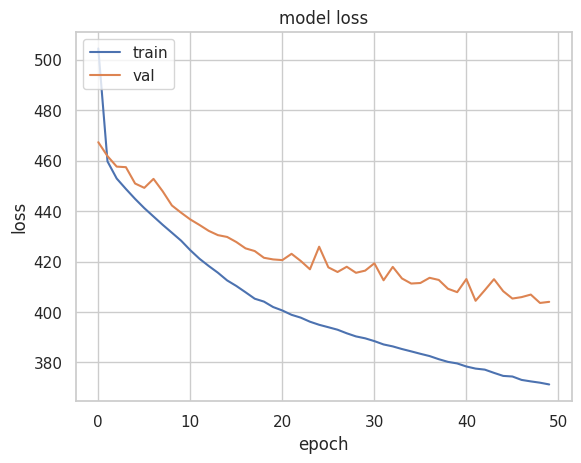

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

На графике видно, что модель начинает переобучаться, так как train_loss уменьшается стремительнее, чем val_loss

Посчитаем важность признаков с помощью permutation importance и визуализируем

713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━

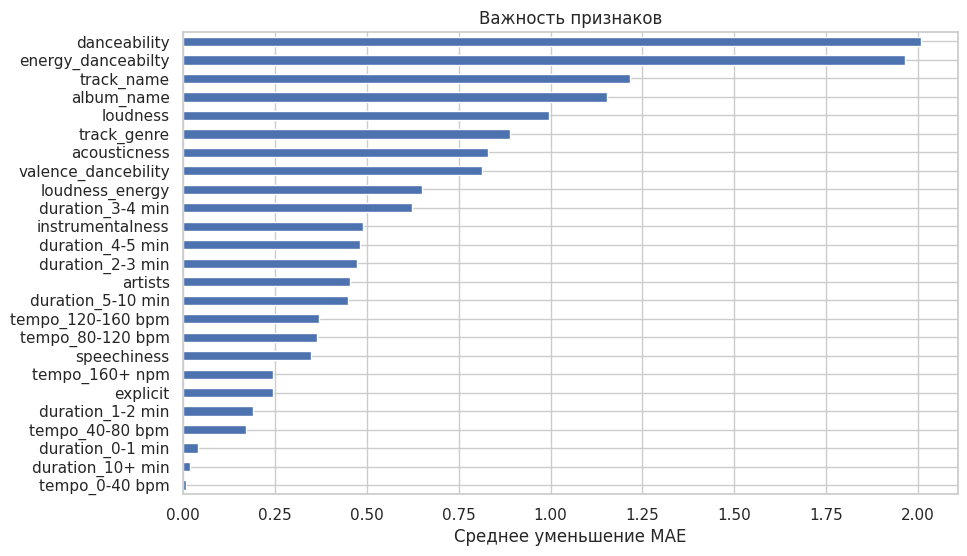

In [ ]:
# Важность признаков с помощью permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')
importances = pd.Series(result.importances_mean, index=X.columns)

# Визуализация важности признаков
importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.title('Важность признаков')
plt.xlabel('Среднее уменьшение MAE')
plt.show()

Одни из самых важных признаков - "Танцевальность", "Энергичность-танцевальность" и "Название трека"

#### Кросс-валидация

In [ ]:
model_wrapper1 = KerasRegressor(model=create_model1, epochs=50, batch_size=32, verbose=0)

In [ ]:
cross_val_model1 = calculate_cross_validate(model_wrapper1)
print_cross_validate(cross_val_model1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Средний MSE: 401.51
Лучший MSE: 390.62

Средний R^2: 0.19
Лучший R^2: 0.21


## Модель 2

In [ ]:
# Build the model
def create_model2():
    model2 = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1)
    ])

    # Compile the model
    model2.compile(optimizer='adam', loss='mean_squared_error')

    return model2

model2 = create_model2()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                     │ (None, 128)                 │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,697 (53.50 KB)

 Trainable params: 13,697 (53.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history2 = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 623.6790 - val_loss: 466.3283
Epoch 2/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 511.9745 - val_loss: 463.4047
Epoch 3/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 502.5002 - val_loss: 455.6610
Epoch 4/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 491.6672 - val_loss: 464.1100
Epoch 5/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 495.9050 - val_loss: 460.8687
Epoch 6/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 485.7971 - val_loss: 451.1292
Epoch 7/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 485.7580 - val_loss: 457.3724
Epoch 8/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 479.5600 - val_loss: 457.2506
Epoch 9/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 480.6364 - val_loss: 445.6530
Epoch 10/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 479.0844 - val_loss: 446.5287
Epoch 11/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 469.1

In [ ]:
# Evaluate the model
loss = model2.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 378.1942
Test Loss: 374.19293212890625


### Результаты обучения

In [ ]:
y_test.value_counts()

popularity
0     3228
21     482
22     459
44     455
1      450
      ... 
95       2
91       1
93       1
96       1
98       1
Name: count, Length: 98, dtype: int64

In [ ]:
y_test.shape

(22800,)

In [ ]:
# Прогнозирование на тестовой выборке
y_pred = model2.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 15.40
MSE: 374.19
RMSE: 19.34
R2: 0.25
MAPE: 15941266785644444.00%


1. **MAE (Mean Absolute Error) — Средняя абсолютная ошибка**
  * Это среднее значение абсолютных разностей между предсказанными и фактическими значениями. MAE показывает, насколько в среднем предсказания модели отличаются от реальных значений.
  * Чем меньше значение MAE, тем лучше модель. Если MAE = 0, то модель предсказывает точно.
2. **MSE (Mean Squared Error) — Среднеквадратичная ошибка**
  * Это среднее значение квадратов разностей между предсказанными и фактическими значениями. MSE усиливает влияние больших ошибок, поскольку они возводятся в квадрат.
  * Меньшее значение MSE указывает на лучшую модель. MSE = 0 означает, что модель идеально предсказывает данные. Эта метрика часто используется в задачах оптимизации модели.
3. **RMSE (Root Mean Squared Error) — Корень среднеквадратичной ошибки**
  * Это квадратный корень из MSE, который возвращает ошибку обратно в единицы измерения исходных данных.
  * RMSE помогает понять средний уровень ошибки в тех же единицах, что и исходные данные. Чем меньше RMSE, тем лучше модель. Оптимально, если RMSE близко к 0.
4. **R² (Коэффициент детерминации)**
  * Эта метрика показывает, какая доля дисперсии зависимой переменной объясняется моделью. Значения R² варьируются от 0 до 1:
    * R² = 1: Модель идеально объясняет все изменения зависимой переменной.
    * R² = 0: Модель не объясняет вообще никакой дисперсии зависимой переменной, предсказывает только среднее значение.
    * R² < 0: Это возможно, если модель даёт худшие предсказания, чем простая модель с постоянным средним значением.
5. **MAPE (Mean Absolute Percentage Error) — Средняя абсолютная процентная ошибка**
  * Она измеряет среднюю процентную ошибку предсказаний модели относительно фактических значений.
  * Чем меньше значение MAPE, тем точнее модель. Значение MAPE = 0% означает идеальную точность. Однако, в случае высоких значений или при работе с нулями в данных, MAPE может быть неустойчивым и вызывать аномальные результаты (как в вашем случае).



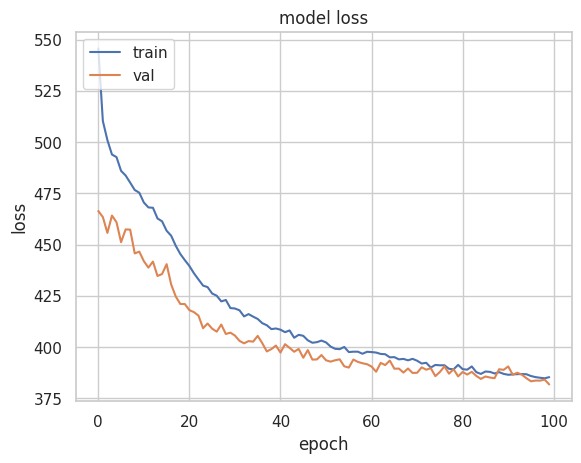

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

На графике видно, что переобучения нет

Посчитаем важность признаков с помощью permutation importance и визуализируем

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━

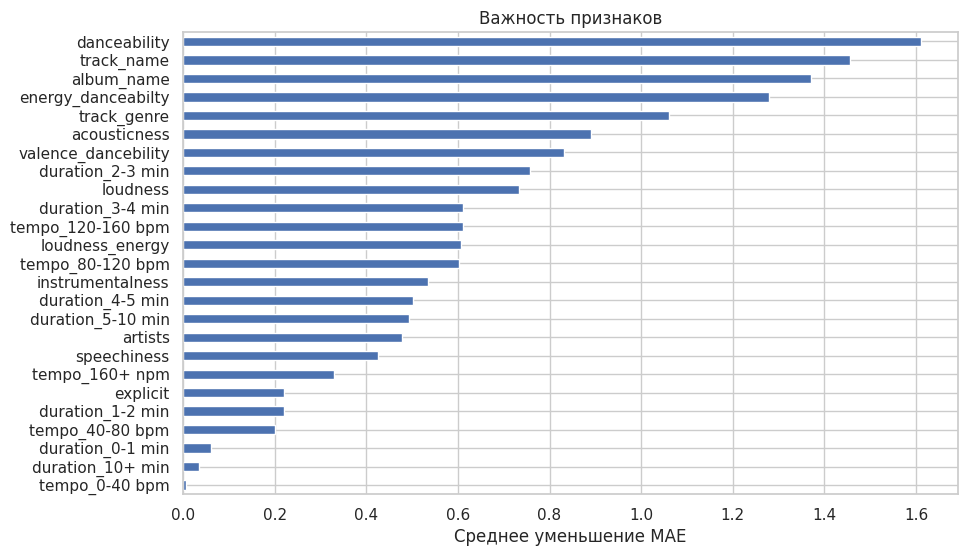

In [ ]:
# Важность признаков с помощью permutation importance
result = permutation_importance(model2, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')
importances = pd.Series(result.importances_mean, index=X.columns)

# Визуализация важности признаков
importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.title('Важность признаков')
plt.xlabel('Среднее уменьшение MAE')
plt.show()

Одни из самых важных признаков - "Танцевальность", "Название трека" и "Название альбома"

#### Кросс-валидация

In [ ]:
model_wrapper2 = KerasRegressor(model=create_model2, epochs=100, batch_size=32, verbose=0)

In [ ]:
cross_val_model2 = calculate_cross_validate(model_wrapper2)
print_cross_validate(cross_val_model2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Средний MSE: 380.94
Лучший MSE: 371.31

Средний R^2: 0.23
Лучший R^2: 0.25


## Линейная регресия

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
def create_linear_regression():
  linear_regression = LinearRegression()

  return linear_regression

linear_regression = create_linear_regression()

In [ ]:
linear_regression.fit(X_train, y_train)

LinearRegression()

### Результаты

In [ ]:
# Прогнозирование на тестовой выборке
y_pred = linear_regression.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

MAE: 18.28
MSE: 481.58
RMSE: 21.94
R2: 0.03
MAPE: 21300619703938776.00%


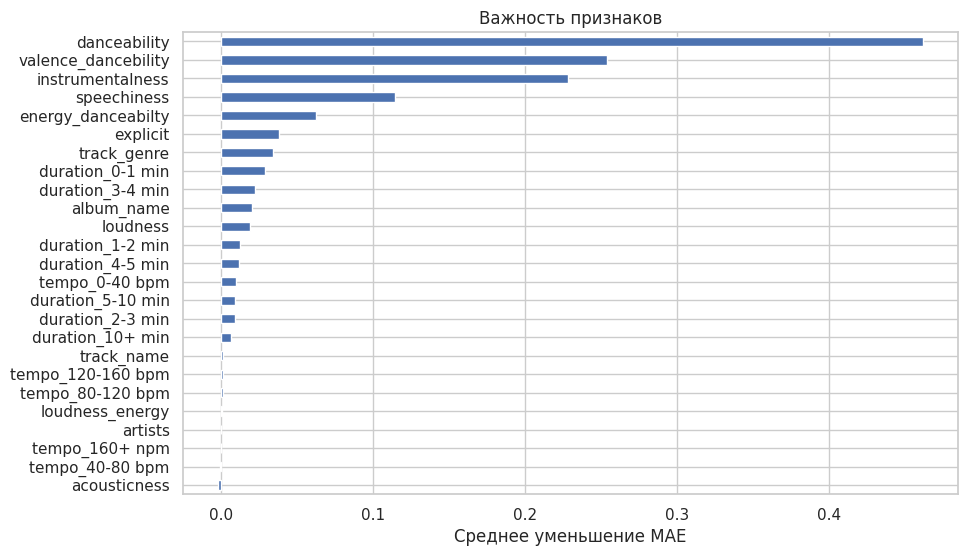

In [ ]:
# Важность признаков с помощью permutation importance
result = permutation_importance(linear_regression, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')
importances = pd.Series(result.importances_mean, index=X.columns)

# Визуализация важности признаков
importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.title('Важность признаков')
plt.xlabel('Среднее уменьшение MAE')
plt.show()

Самыми важными признаками являются:"Танцевальность", "Настроение-танцевальность" и "Инструментальность"

#### Кросс-валидация

In [ ]:
cross_validate_linear = calculate_cross_validate(create_linear_regression())
print_cross_validate(cross_validate_linear)

Средний MSE: 481.13
Лучший MSE: 476.45

Средний R^2: 0.03
Лучший R^2: 0.03


## Random Forest

Для подбора параметров использовал GridSearch. После нахождения оптимальных параметров, решил создавать модель с этими параметрами, а код GridSearch закомментировал (для экономии времени).

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
def create_random_forest():
  random_forest = RandomForestRegressor(
      random_state=42,
      max_depth=14,
      min_samples_leaf=1,
      min_samples_split=2,
      n_estimators=15
  )

  return random_forest

random_forest = create_random_forest()

In [ ]:
random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=14, n_estimators=15, random_state=42)

In [ ]:
# param_grid = {
#     'n_estimators': [5, 10, 15],
#     'max_depth': [5, 8, 11, 14],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 3, 5]
# }

In [ ]:
# grid_forest = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

In [ ]:
# grid_forest.fit(X_train, y_train)

In [ ]:
# random_forest = grid_forest.best_estimator_

In [ ]:
# print("Лучшие параметры Random Forest:", grid_forest.best_params_)
# print("Лучшее значение ошибки (MSE):", -grid_forest.best_score_)

С помощью GridSearch были найдены следующие гиперпараметры:

Лучшие параметры Random Forest: `{'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 15}`

Лучшее значение ошибки (MSE): 317.5052163854814

### Результаты

In [ ]:
# Прогнозирование на тестовой выборке
y_pred = random_forest.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

MAE: 13.74
MSE: 309.71
RMSE: 17.60
R2: 0.38
MAPE: 13446025069625536.00%


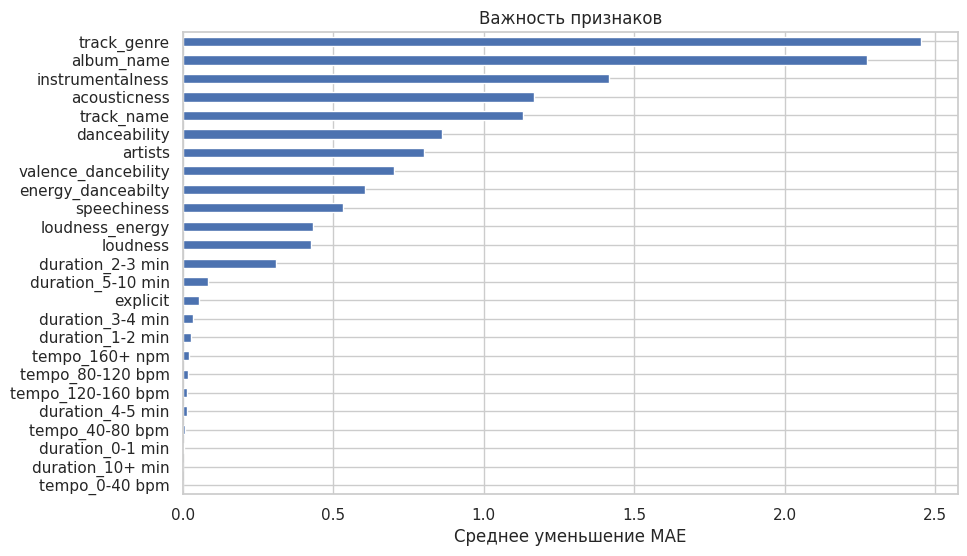

In [ ]:
result = permutation_importance(random_forest, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')
importances = pd.Series(result.importances_mean, index=X.columns)

# Визуализация важности признаков
importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.title('Важность признаков')
plt.xlabel('Среднее уменьшение MAE')
plt.show()

Одними из самых важных признаков являются: "Жанр трека", "Название альбома" и "Инструментальность трека"

#### Кросс-валидация

In [ ]:
cross_val_random_forest = calculate_cross_validate(create_random_forest())
print_cross_validate(cross_val_random_forest)

Средний MSE: 315.91
Лучший MSE: 308.88

Средний R^2: 0.37
Лучший R^2: 0.38


## Градиентный бустинг

Для подбора параметров использовал GridSearch. После нахождения оптимальных параметров, решил создавать модель с этими параметрами, а код GridSearch закомментировал (для экономии времени).

In [ ]:
from xgboost import XGBRegressor

In [ ]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

In [ ]:
def create_xgb():
  xgb = XGBRegressor(
      random_state=42,
      colsample_bytree=1.0,
      learning_rate=0.2,
      max_depth=7,
      n_estimators=300,
      subsample=1.0
  )
  return xgb

xgb = create_xgb()

In [ ]:
# grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

In [ ]:
# grid_xgb.fit(X_train, y_train)

In [ ]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# xgb = grid_xgb.best_estimator_

In [ ]:
# print("Лучшие параметры LightGBM:", grid_xgb.best_params_)
# print("Лучшее значение ошибки (MSE):", -grid_xgb.best_score_)

Лучшие параметры LightGBM: `{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}`

Лучшее значение ошибки (MSE): 203.37820067583917

### Результаты

In [ ]:
# Прогнозирование на тестовой выборке
y_pred = xgb.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

MAE: 10.17
MSE: 186.92
RMSE: 13.67
R2: 0.62
MAPE: 8434966410754670.00%


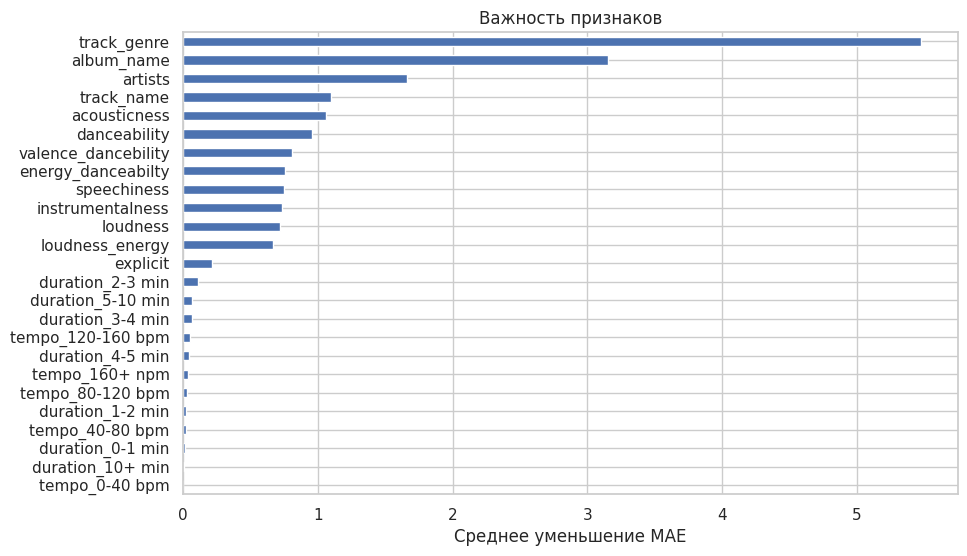

In [ ]:
result = permutation_importance(xgb, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')
importances = pd.Series(result.importances_mean, index=X.columns)

# Визуализация важности признаков
importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.title('Важность признаков')
plt.xlabel('Среднее уменьшение MAE')
plt.show()

Самыми важными признаками являются: "Жанр трека", "Название альбома" и "Артист"

#### Кросс-валидация

In [ ]:
cross_val_xgb = calculate_cross_validate(create_xgb())
print_cross_validate(cross_val_xgb)

Средний MSE: 197.81
Лучший MSE: 193.73

Средний R^2: 0.6
Лучший R^2: 0.61


# Сравнение моделей

In [ ]:
print('model1')
print('='*20)
print_cross_validate(cross_val_model1)
print('='*20)
print()

print('model2')
print('='*20)
print_cross_validate(cross_val_model2)
print('='*20)
print()

print('Линейная')
print('='*20)
print_cross_validate(cross_validate_linear)
print('='*20)
print()

print('Random Forest')
print('='*20)
print_cross_validate(cross_val_random_forest)
print('='*20)
print()

print('Градиентный бустинг')
print('='*20)
print_cross_validate(cross_val_xgb)

model1
Средний MSE: 401.51
Лучший MSE: 390.62

Средний R^2: 0.19
Лучший R^2: 0.21

model2
Средний MSE: 380.94
Лучший MSE: 371.31

Средний R^2: 0.23
Лучший R^2: 0.25

Линейная
Средний MSE: 481.13
Лучший MSE: 476.45

Средний R^2: 0.03
Лучший R^2: 0.03

Random Forest
Средний MSE: 315.91
Лучший MSE: 308.88

Средний R^2: 0.37
Лучший R^2: 0.38

Градиентный бустинг
Средний MSE: 197.81
Лучший MSE: 193.73

Средний R^2: 0.6
Лучший R^2: 0.61


1. Нейронные сети:
  * model1:
    * Средний MSE: 401.51
    * Лучший MSE: 390.62
    * Средний R²: 0.19 - указывает на слабую объясняющую способность
    
  * model2:
    * Средний MSE: 380.94 - лучше, чем у model1
    * Лучший MSE: 371.31
    * Средний R²: 0.23 - выше, чем у model1, но всё ещё недостаточно для хорошего качества

2. Линейная модель:
  * Средний MSE: 481.13 - худшее значение среди всех моделей
  * Лучший MSE: 476.45
  * Средний R²: 0.03 - указывает на неспособность линейной модели объяснить сложные зависимости

3. Random Forest:
  * Средний MSE: 315.91
  * Лучший MSE: 308.88
  * Средний R²: 0.37 - значительное улучшение по сравнению с нейронными сетями
  
4. Градиентный бустинг (XGBoost):
  * Средний MSE: 197.81 - лучший результат
  * Лучший MSE: 193.73
  * Средний R²: 0.60 - указывает на высокую объясняющую способность модели

Модель, показавшая лучшие результаты - градиентный бустинг XGBoost

# Итог

В ходе данной работы я изучил задачу машинного обучения — регрессию. Освоил построение нового для меня типа графиков — BoxPlot. Познакомился с моделями машинного обучения: линейная модель, Random Forest и градиентный бустинг (XGBoost), а также обучил их. Для повышения качества моделей использовал подбор гиперпараметров с помощью GridSearch. В завершение работы я провёл оценку и сравнение эффективности моделей машинного и глубокого обучения, применяя кросс-валидацию.